# Patient-specific MDS-RS iPSCs define the mis-spliced transcript repertoire and chromatin landscape of SF3B1-mutant HSPCs

This notebook contains the code necessary to reproduce the figures of the paper.

## Environment Setup

In [2]:
rm(list=ls())
working_directory <- "./"
data_directory <- "./../data/"
results_directory <- "./../results/"
setwd(working_directory)

In [ ]:
library(factoextra)
library(ggfortify)
library(RColorBrewer)
library(pheatmap)
library(EnhancedVolcano)
library(DESeq2)
library(gridExtra)
library(stringr)
library(viridis)
library(BuenColors)
library(VennDiagram)
library(dplyr)
library(rtracklayer)
library(plotrix)
library(reshape2)

#### Configuration metadata and annotation

In [4]:
donors <- c('donor21','donor22','donor23')
iPSC_lines <- c('donor21.N21_6',
                'donor21.N21_14',
                'donor21.N21_1',
                'donor22.N22_27',
                'donor22.N22_22',
                'donor22.N22_45',
                'donor23.N23_5',
                'donor23.N23_13',
                'donor23.N23_28',
                'donor21.MDS21_29',
                'donor21.MDS21_31',
                'donor21.MDS21_16',
                'donor22.MDS22_44b',
                'donor23.MDS23_24',
                'donor23.MDS23_6',
                'donor23.MDS23_38')

In [5]:
infile <- paste(data_directory,'iPSC/annotation_map.tsv',sep="")
annotation_map <- read.table(infile,header=T,sep="\t", stringsAsFactors = F)

## RNA-seq Analysis

#### Reading gene expression object and producing PCA plots and heatmap based on gene counts

In [6]:
infile <- paste(data_directory,"iPSC/dds.rds",sep="")
dds <- readRDS(infile)

In [7]:
rlognorm <- rlog(dds, blind=FALSE)
counts_rlognorm_all <- as.matrix(assay(rlognorm))

ntop=3000

rv <- rowVars(counts_rlognorm_all)
select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]
highly_variant<-rownames(counts_rlognorm_all)[select]
counts_rlognorm<-counts_rlognorm_all[select,]

counts_rlognorm.pca_var <- prcomp(t(counts_rlognorm), center = TRUE,scale. = TRUE)

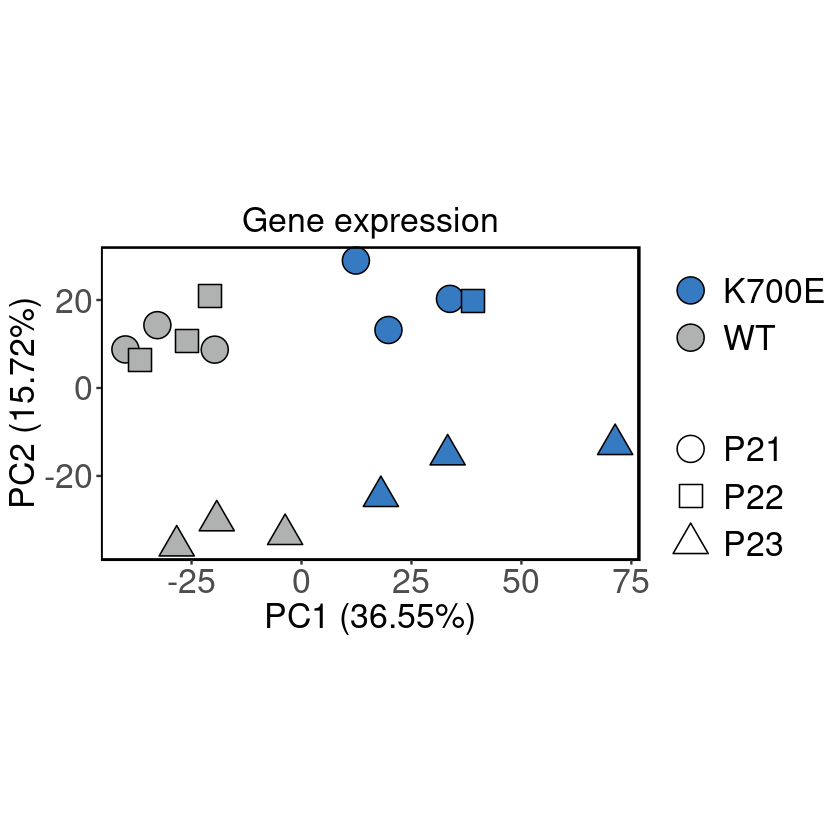

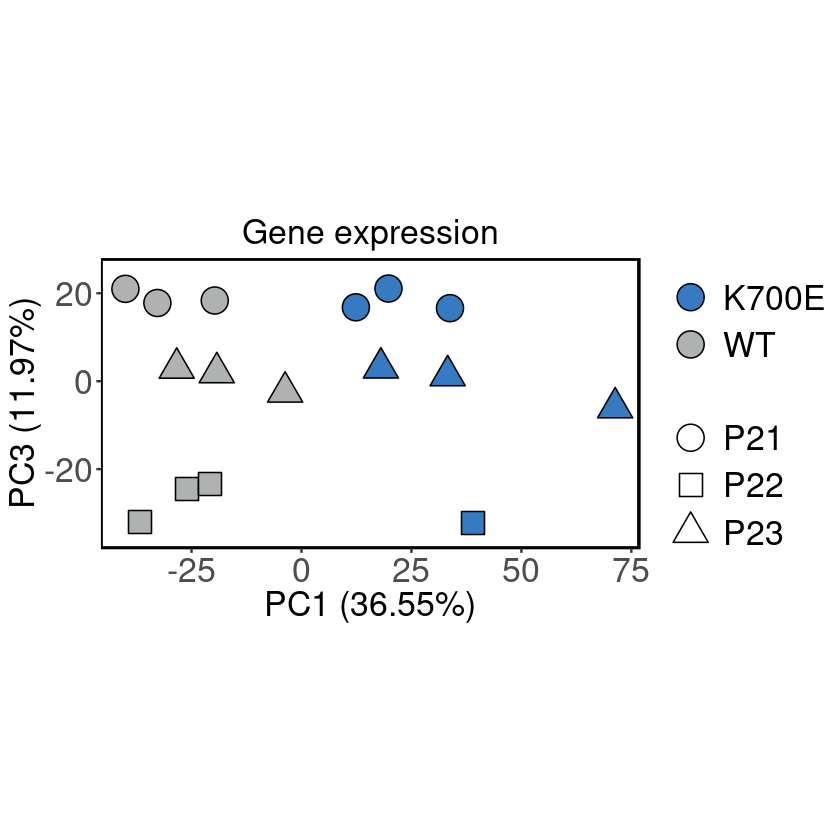

In [8]:
temp <- as.data.frame(colData(dds),stringsAsFactors = F)
temp$condition_factor <- str_replace(temp$condition_factor,"Normal","WT")
temp$condition_factor <- str_replace(temp$condition_factor,"MDS","K700E")
temp$individ_factor <- as.character(temp$individ_factor)
category <- temp
category$individ_factor <- gsub("donor","P",category$individ_factor)

autoplot(counts_rlognorm.pca_var,x = 1, y = 2,scale=0,data=cbind(t(counts_rlognorm),category),fill="condition_factor",shape="individ_factor",size=7,label=FALSE) +
        scale_fill_manual(values=c("#367BC1","#B0B2B1")) + scale_shape_manual(values=c(21, 22, 24))+ ggtitle("Gene expression")+ theme_bw() +
        theme(legend.text=element_text(size=20),axis.text=element_text(size=20,family="Arial"), legend.key.size = unit(1, "cm"),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.border = element_rect(colour = "black", fill=NA, size=1),
              axis.title=element_text(size=20,family="Arial"),plot.title=element_text(size=20,hjust = 0.5,family="Arial")) +
        labs(fill="",shape="") + guides(fill = guide_legend(override.aes = list(shape = 21)),shape = guide_legend(override.aes = list(size = 7))) + coord_fixed()

autoplot(counts_rlognorm.pca_var,x = 1, y = 3,scale=0,data=cbind(t(counts_rlognorm),category),fill="condition_factor",shape="individ_factor",size=7,label=FALSE) +
        scale_fill_manual(values=c("#367BC1","#B0B2B1"))+ scale_shape_manual(values=c(21, 22, 24))+ ggtitle("Gene expression")+ ylim(-35,25)+ theme_bw() +
        theme(legend.text=element_text(size=20),axis.text=element_text(size=20,family="Arial"), legend.key.size = unit(1, "cm"), legend.spacing.y = unit(0.1, 'cm'),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.border = element_rect(colour = "black", fill=NA, size=1),
              axis.title=element_text(size=20,family="Arial"),plot.title=element_text(size=20,hjust = 0.5,family="Arial")) + 
        labs(fill="",shape="") + guides(fill = guide_legend(override.aes = list(shape = 21)),shape = guide_legend(override.aes = list(size = 7))) + coord_fixed()

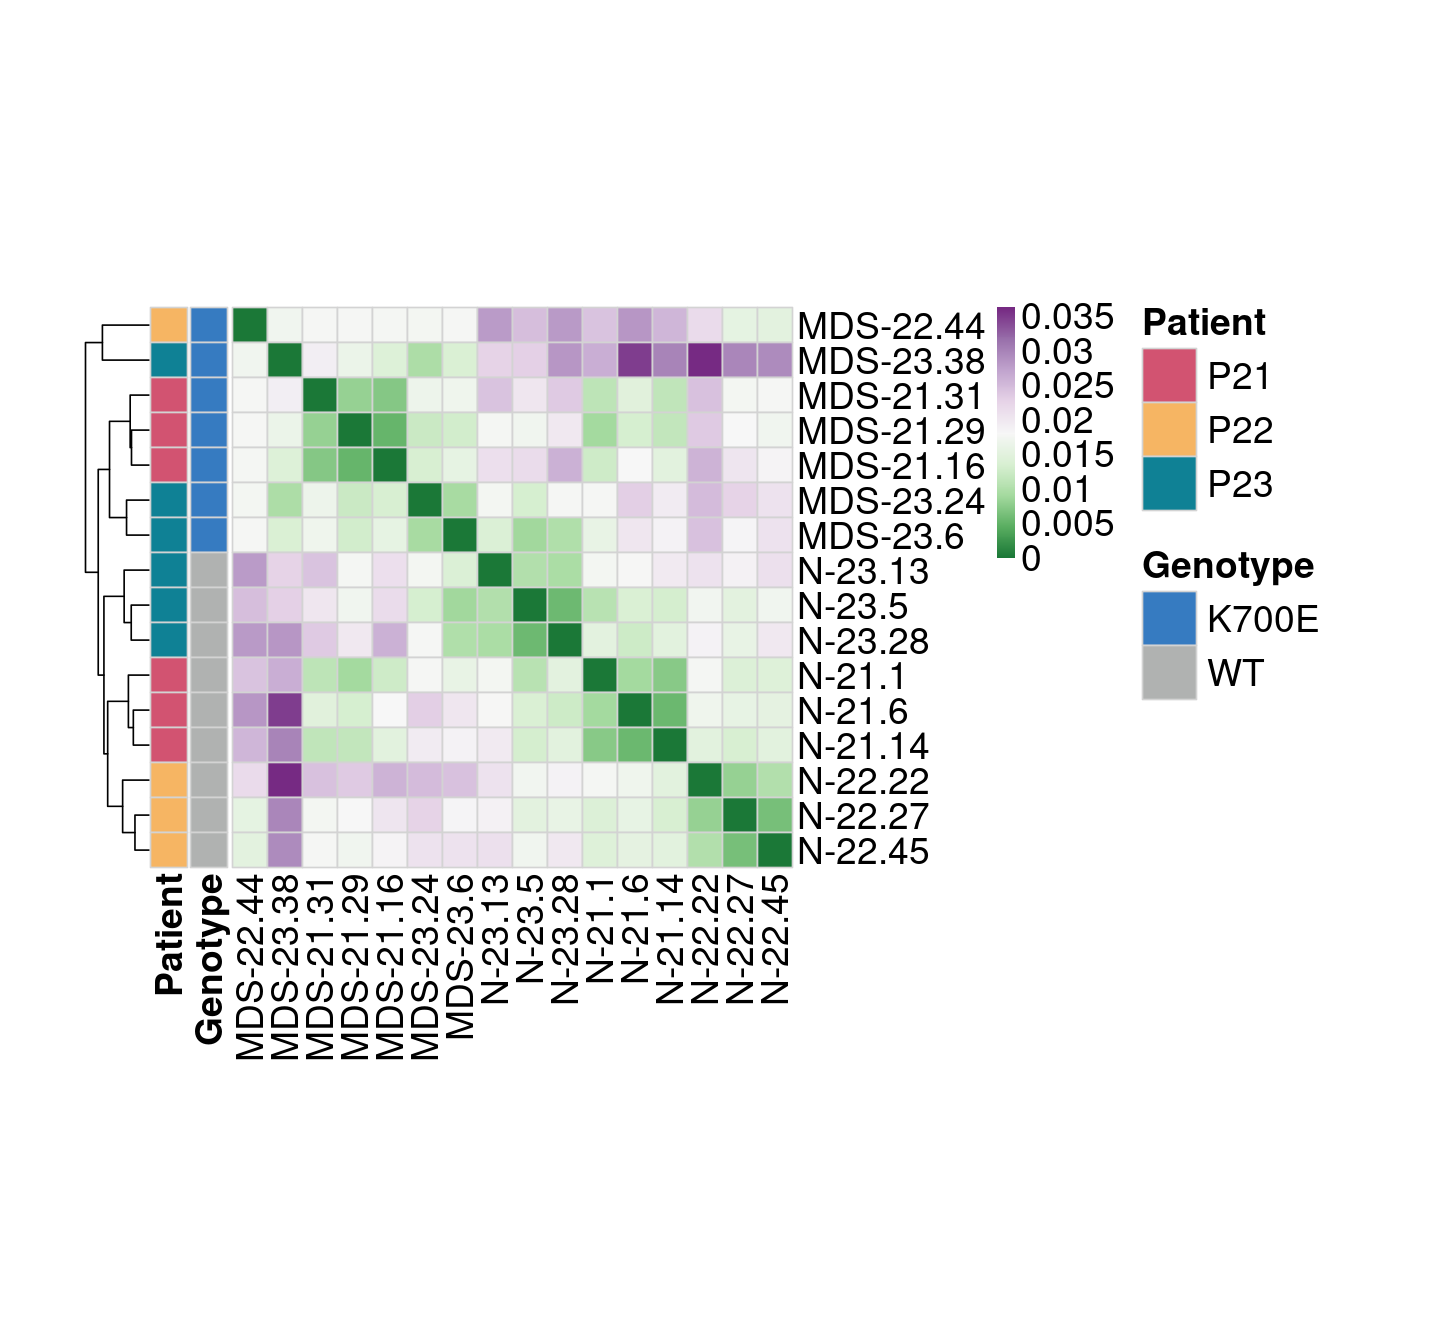

In [9]:
options(repr.plot.width=12, repr.plot.height=11)

testcorpearpeak <- 1 - cor(counts_rlognorm_all,method="pearson")
testsampleDistMatrixpeak <- as.matrix(testcorpearpeak)

colours = colorRampPalette(rev(brewer.pal(9, "PRGn")))(255)

data_pheat <- testsampleDistMatrixpeak

colnames(data_pheat) <- lapply(colnames(data_pheat),function(x){strsplit(x,"\\.")[[1]][[2]]})
colnames(data_pheat) <- str_replace(colnames(data_pheat),"_",".")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS","MDS-")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"N","N-")
rownames(data_pheat) <- colnames(data_pheat)
my_samples_col <- sapply(colnames(data_pheat),function(x){strsplit(x,"-")[[1]][[1]]})
my_samples_col <- str_replace(my_samples_col,"MDS","K700E")
my_samples_col <- str_replace(my_samples_col,"N","WT")
names(my_samples_col) <- colnames(data_pheat)
my_samples_col <- as.data.frame(my_samples_col,stringsAsFactors = F)
colnames(my_samples_col) <- "Genotype"

my_samples_col$Patient <- rownames(my_samples_col)
my_samples_col$Patient <- sapply(rownames(my_samples_col),function(x){strsplit(x,"-")[[1]][[2]]})
my_samples_col$Patient <- sapply(my_samples_col$Patient,function(x){strsplit(x,"\\.")[[1]][[1]]})
my_samples_col$Patient <- paste("P",my_samples_col$Patient,sep="")
my_colour = list(Genotype = c(K700E = "#367BC1", WT = "#B0B2B1"),
                Patient = c(P21 = "#D25371",P22="#F6B563",P23="#0F8195"))

rownames(my_samples_col) <- str_replace(rownames(my_samples_col),"MDS-22.44b","MDS-22.44")
rownames(data_pheat) <- str_replace(rownames(data_pheat),"MDS-22.44b","MDS-22.44")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS-22.44b","MDS-22.44")

pheatmap(data_pheat,color=colours,clustering_method = "average",annotation_colors = my_colour, show_rownames = TRUE, show_colnames = TRUE, angle_col="90",
         cellheight=21,cellwidth=21,cutree_rows = 1,cutree_cols = 1,fontsize=22,border_color="lightgrey",fontsize_col=22,fontface="plain", fontfamily = 'Arial',
         fontsize_row=22,cex=1,treeheight_col = 0,treeheight_row = 35,annotation_row = my_samples_col,main="",annotation_legend=TRUE)

#### Performing differential gene expression (DGE) analysis and identifying differentially expressed genes

In [10]:
query <- "MDS"
ref <- "Normal"
    
nms <- paste(query,"_",ref,sep="")
    
project_res <- results(dds,contrast=c("condition_factor",query,ref),alpha=0.05)
project_res <- lfcShrink(dds, contrast=c("condition_factor",query,ref), res=project_res)

project_res_sort <- project_res[order(project_res$padj), ]

if (!dir.exists(results_directory)){
    dir.create(results_directory)
}
    
dif_outfile<-paste(results_directory,nms,"_dge_mat_before_filt.txt",sep="")
write.table(as.data.frame(project_res_sort), file=dif_outfile, row.names=T, col.names=T, sep="\t", quote = FALSE)
        
index <- project_res_sort$padj<0.05
index[is.na(index)] <- FALSE
project_diff_exp <- project_res_sort[index,]
    
project_diff_exp <- project_diff_exp[abs(project_diff_exp$log2FoldChange)>=1.0,]   
project_gene_names <- rownames(project_diff_exp)
        
dif_outfile <- paste(results_directory,nms,"_dge_genes.txt",sep="")
write.table(as.data.frame(project_gene_names), file=dif_outfile, row.names=F, col.names=F, sep="\t", quote = FALSE)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).
additional priors are available via the 'type' argument, see ?lfcShrink for details


Volcano Plot for gene expression

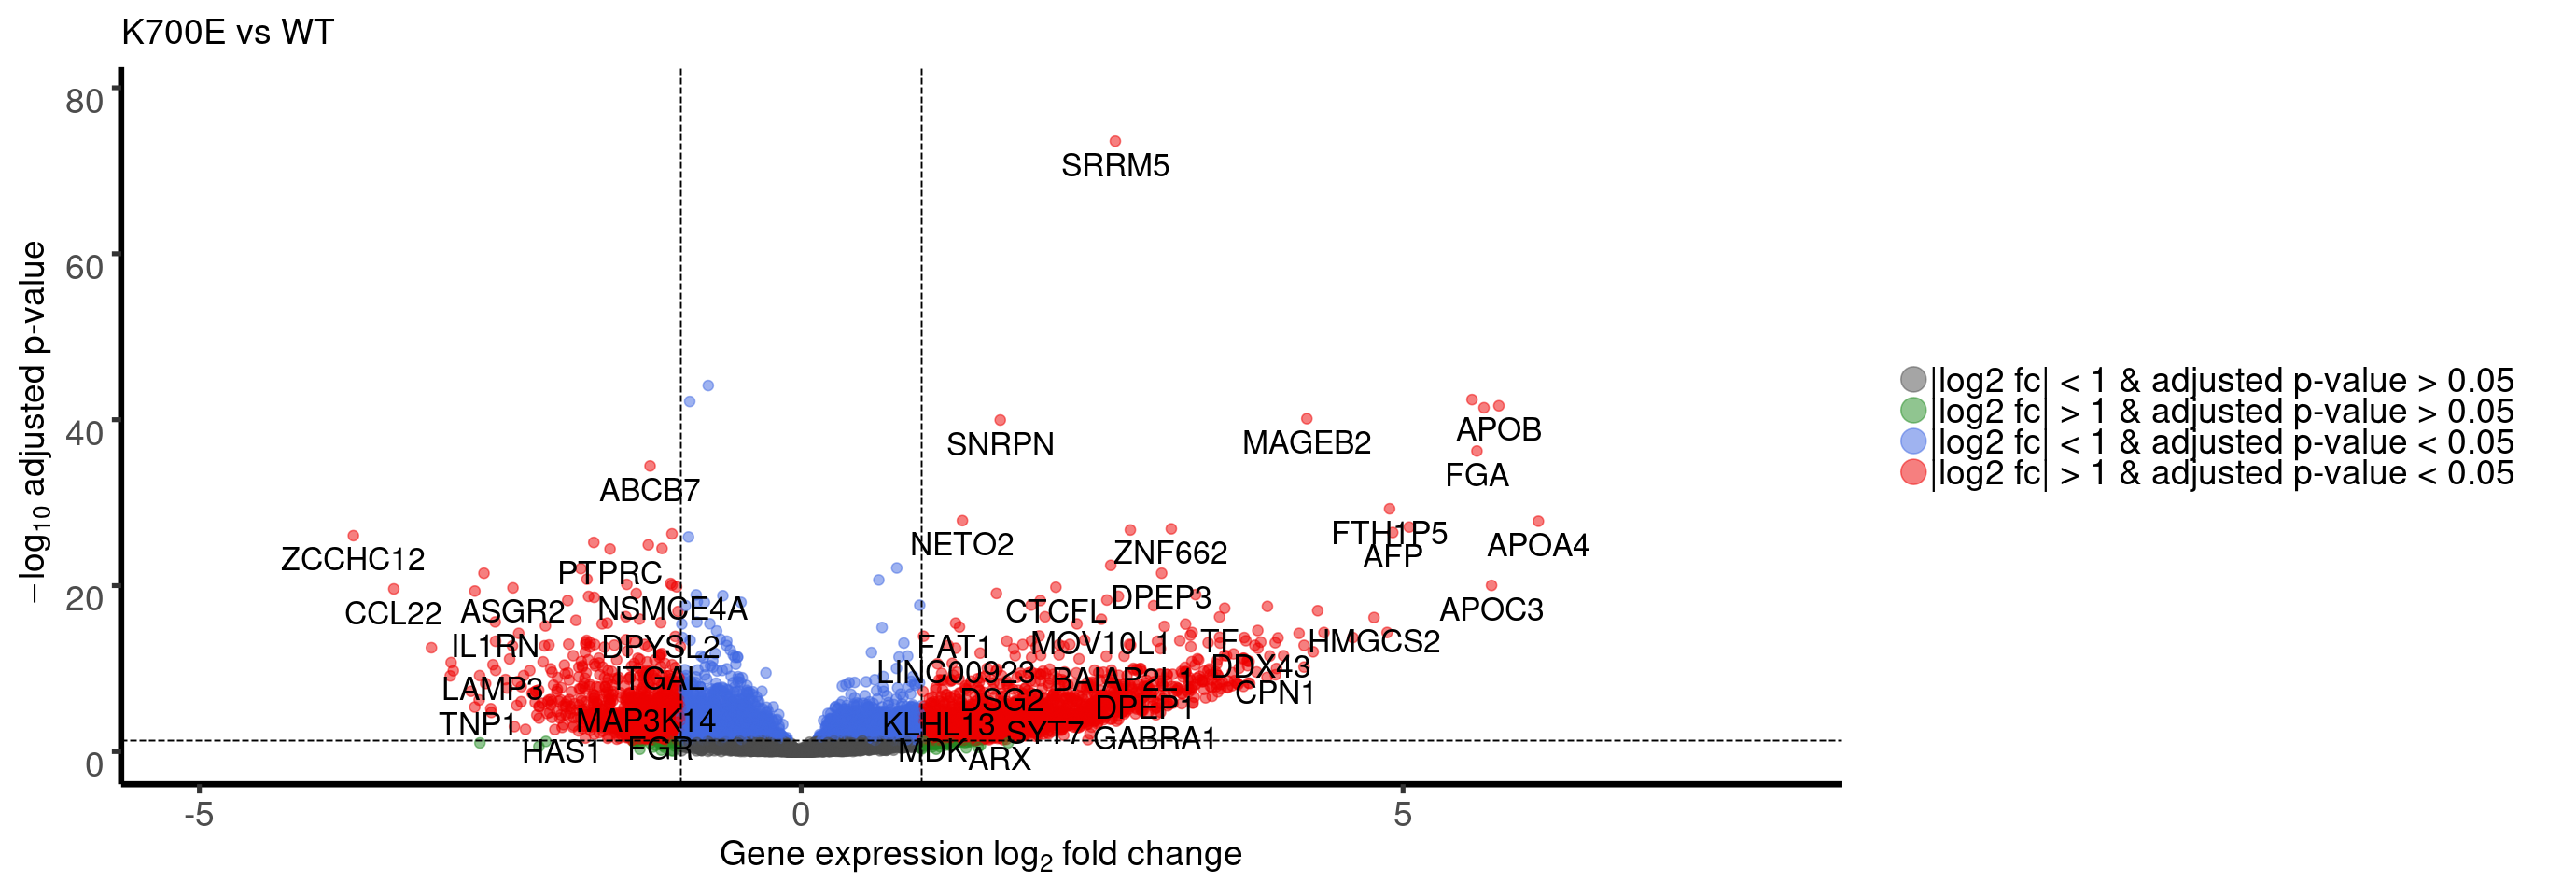

In [11]:
options(repr.plot.width=23, repr.plot.height=8)

temp <- project_res
rownames(temp) <- as.vector(sapply(rownames(temp),function(x) {unique(annotation_map[which(annotation_map$GENEID==x),]$make_genename)}))
temp <- temp[!is.na(temp$padj),]

EnhancedVolcano(temp,lab = rownames(temp),x = 'log2FoldChange',y = 'padj',title = "",xlim=c(-5,8), xlab = bquote('Gene expression'~log[2]~'fold change'),
                borderWidth = 1.4, axisLabSize = 22,titleLabSize=22, ylab = bquote(~-log[10]~'adjusted p-value'), pCutoff = 0.05, FCcutoff = 1.0,
                legend=c('|log2 fc| < 1 & adjusted p-value > 0.05','|log2 fc| > 1 & adjusted p-value > 0.05',
                         '|log2 fc| < 1 & adjusted p-value < 0.05','|log2 fc| > 1 & adjusted p-value < 0.05'),
                legendPosition = 'right',legendLabSize = 22,legendIconSize = 7.0,  transcriptPointSize = 2.5,transcriptLabSize = 7,gridlines.major = FALSE,
                gridlines.minor = FALSE)+ ggtitle("K700E vs WT") + theme(legend.text=element_text(face = "plain",family='DejaVu Sans Condensed'),
                                                                         plot.title = element_text(face = "plain",family='DejaVu Sans Condensed'))

Heatmap using differentially expressed genes

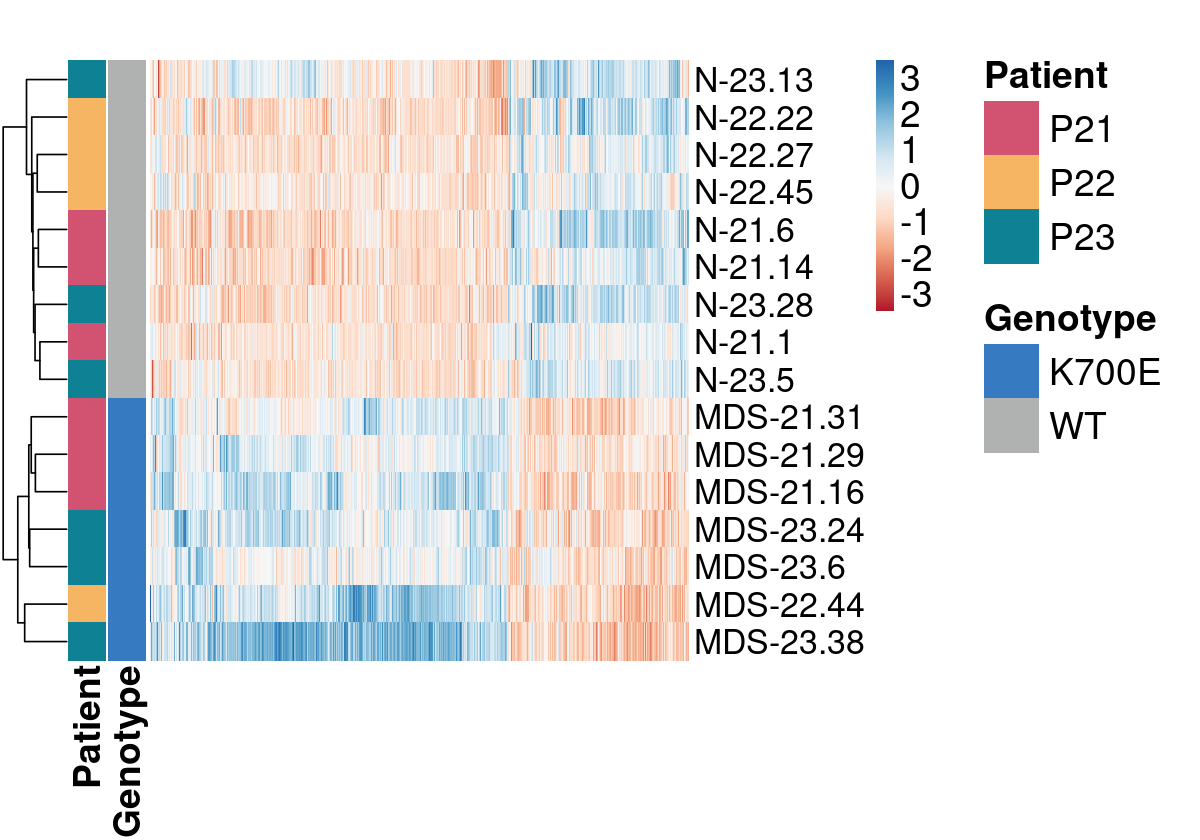

In [12]:
options(repr.plot.width=10, repr.plot.height=7)

colours2 = colorRampPalette(brewer.pal(9, "RdBu"))(255)

data_pheat <- as.matrix(counts_rlognorm_all[project_gene_names,])

colnames(data_pheat) <- lapply(colnames(data_pheat),function(x){strsplit(x,"\\.")[[1]][[2]]})
colnames(data_pheat) <- str_replace(colnames(data_pheat),"_",".")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS","MDS-")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"N","N-")

rownames(data_pheat) <- str_replace(rownames(data_pheat),"MDS-22.44b","MDS-22.44")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS-22.44b","MDS-22.44")

pheatmap(t(data_pheat),color=colours2, clustering_method = "average",annotation_colors = my_colour, annotation_row = my_samples_col, angle_col = "90",
         scale = "column", show_rownames = TRUE, show_colnames = FALSE, cluster_rows = TRUE, cluster_cols = TRUE,treeheight_row = 35,treeheight_col = 0,
         fontsize=22,border_color="lightgrey",fontsize_col=22,main="", fontsize_row=20,cex=1)

#### Reading dataframe of differentially splicing events and examining their inclusion levels and types  

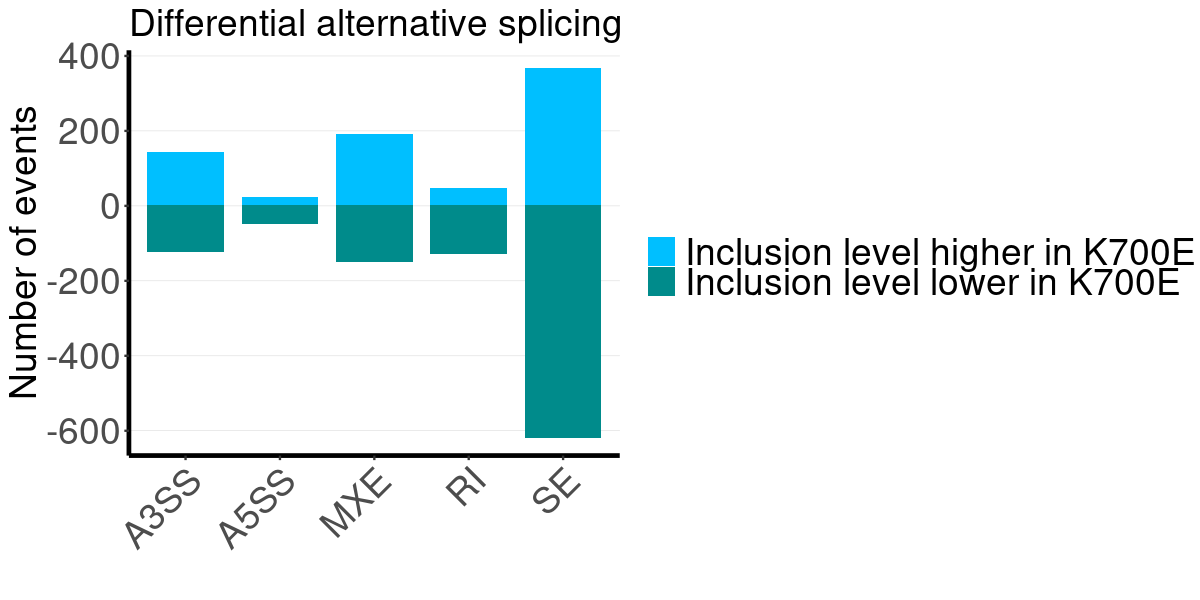

In [13]:
options(repr.plot.width=10, repr.plot.height=5) 

infile <- paste(data_directory,'iPSC/total_splicing_events.tsv',sep="")
total_data_scatter <- read.table(infile,header=TRUE,sep="\t",stringsAsFactors = F)

events<-c("A3SS","A5SS","MXE","RI","SE")

ev_up_MDS<-sapply(events,function(x){sum(total_data_scatter$dpsi_sign==1 & total_data_scatter$event_type==x)})
ev_up_Normal<-sapply(events,function(x){sum(total_data_scatter$dpsi_sign==-1 & total_data_scatter$event_type==x)})
dat_all<-data.frame("events"=c(names(ev_up_MDS),names(ev_up_Normal)),"counts"=c(ev_up_MDS,-ev_up_Normal),cat=c(rep("Inclusion level higher in K700E",length(ev_up_MDS)),rep("Inclusion level lower in K700E",length(ev_up_Normal))))

ggplot(dat_all, aes(x=events, y=counts, fill=cat)) + geom_bar(stat="identity", position="identity",width=0.8) + theme_classic()+ ggtitle("Differential alternative splicing")+ 
        theme(legend.text=element_text(size=22,family="Arial"),axis.text=element_text(size=22,family="Arial"),axis.text.x=element_text(angle=45, hjust=1,family="Arial"),
              axis.title=element_text(size=22,family="Arial"), plot.subtitle=element_text(size=12,family="Arial"),axis.line = element_line(colour = 'black', size = 1),
              panel.grid.major.x = element_blank(),panel.grid.major.y = element_line( size=.1, color="lightgrey"), plot.title=element_text(face="plain",size=22,family="Arial"))+
        scale_fill_manual(values=c("deepskyblue1","darkcyan"))+ labs(fill="",x="",y="Number of events")

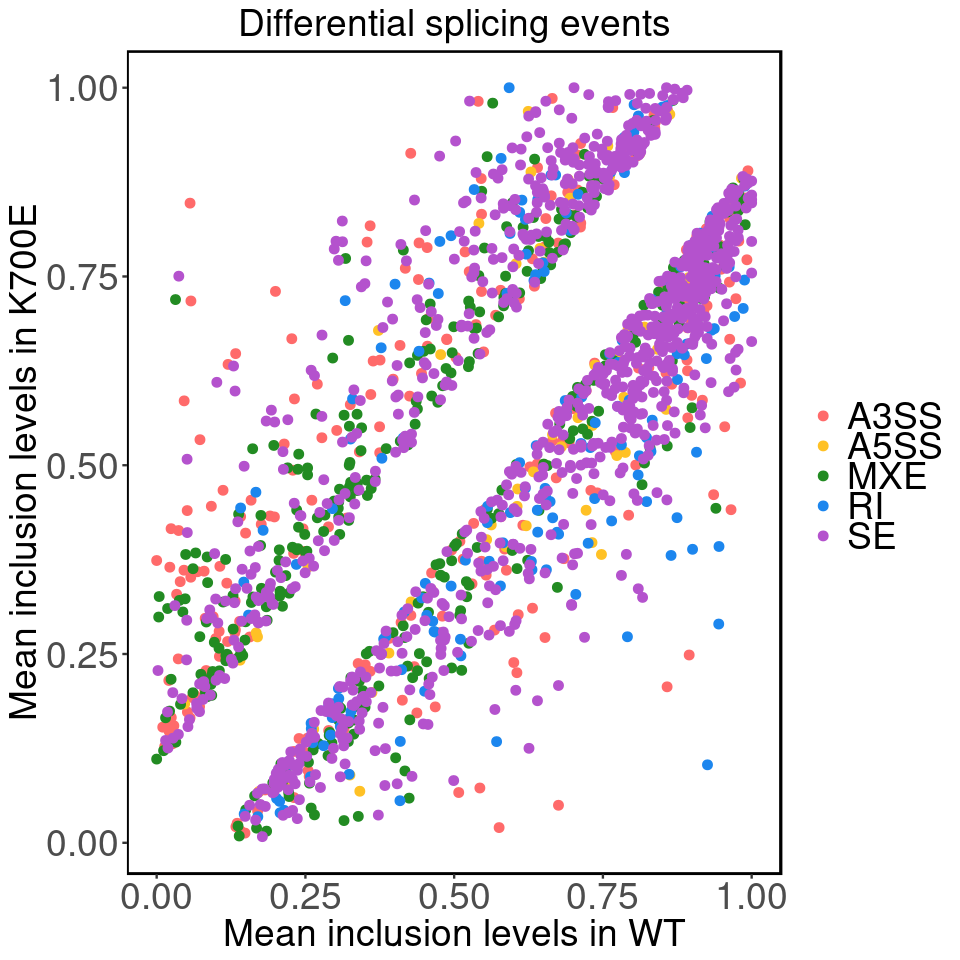

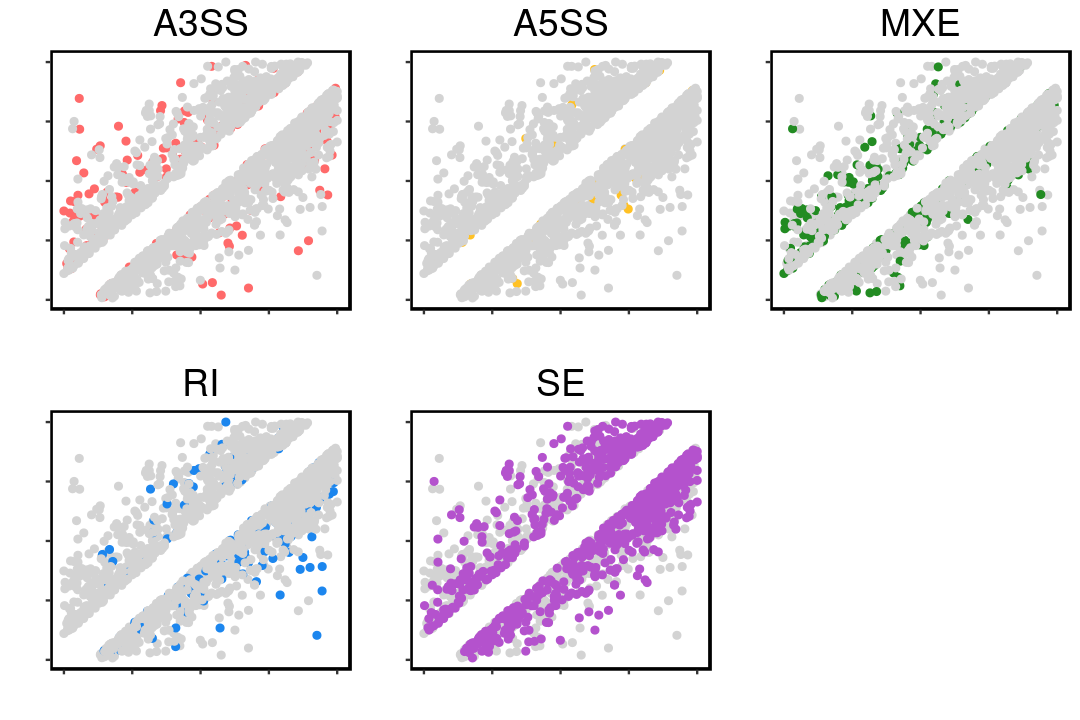

In [14]:
options(repr.plot.width=8, repr.plot.height=8) 

mycols_events <- c("A3SS" = 'indianred1', "A5SS" = 'goldenrod1', "MXE" = "forestgreen", "RI" = "dodgerblue2", "SE" = "mediumorchid3")

ggplot(total_data_scatter, aes(y=MDSmean, x=Normalmean, color=event_type)) + geom_point(size = 2)+ 
        labs(y="Mean inclusion levels in K700E",x="Mean inclusion levels in WT",color="") + 
        ggtitle("Differential splicing events") + scale_color_manual(values=mycols_events) + 
        theme_bw() + theme(legend.text=element_text(size=22,family="Arial"),
                           axis.text=element_text(size=22,family="Arial"),
                           panel.grid.major = element_blank(), 
                           panel.grid.minor = element_blank(),
                           panel.border = element_rect(colour = "black", fill=NA, size=1),
                           axis.title=element_text(size=22,family="Arial"),
                           plot.title=element_text(size=22,hjust=0.5,family="Arial"))

pltlist <- list()

for (iev in events){
    
    total_data_scatter$tocolor <- iev
    total_data_scatter[which(as.character(total_data_scatter$event_type)!=iev),]$tocolor = "other"
    total_data_scatter$tocolor <- factor(total_data_scatter$tocolor,levels=c(iev,"other"))
    pltlist[[iev]] <- ggplot(total_data_scatter, aes(y=MDSmean, x=Normalmean, color=tocolor)) + geom_point(size = 1.5)+
                            labs(y="",x="",color="") + ggtitle(paste("",iev,sep="")) +
                            scale_color_manual(values=c(mycols_events[[iev]],"lightgrey"),
                                               labels=c(iev,"other"))+
                            theme_bw() + theme(legend.position="none",legend.text=element_text(size=22,family="Arial"),
                                               axis.text=element_blank(),panel.grid.major = element_blank(),
                                               panel.grid.minor = element_blank(),
                                               panel.border = element_rect(colour = "black", fill=NA, size=1),
                                               axis.title=element_text(size=22,family="Arial"),
                                               plot.title=element_text(size=22,hjust=0.5,family="Arial"))
} 

options(repr.plot.width=9, repr.plot.height=6)
grid.arrange(grobs=pltlist, nrow=2 ,as.table=TRUE)

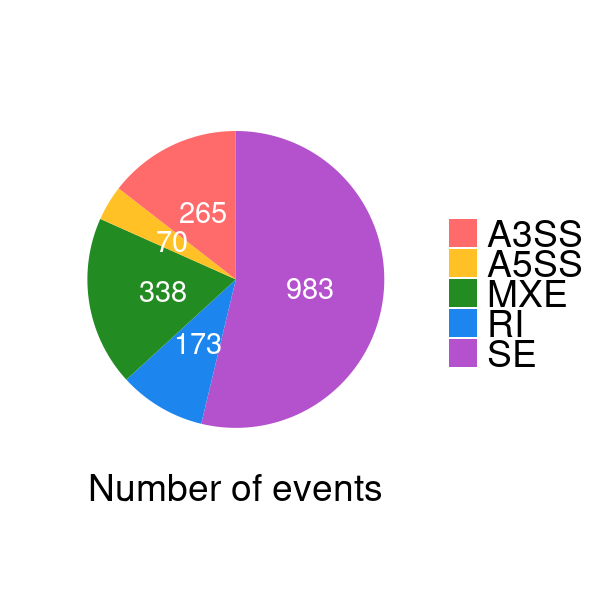

In [15]:
options(repr.plot.width=6, repr.plot.height=6) 

count_common_events<-as.data.frame(table(total_data_scatter$event_type))
colnames(count_common_events)<-c("event_type","counts")

options(repr.plot.width=5, repr.plot.height=5) 

ggplot(data=count_common_events, aes(x="",y=counts, fill=event_type)) + geom_bar(stat="identity") + coord_polar("y", start=0) + theme_classic() +  
        geom_text(aes(y = counts,label=counts),family="Arial",color="white",size=6,position = position_stack(vjust = 0.5))+
        scale_fill_manual(values=mycols_events) + theme(axis.line = element_blank(),axis.text = element_blank(),
                                                        axis.ticks = element_blank(),
                                                        legend.text=element_text(size=22,family="Arial"),
                                                        axis.title=element_text(size=22,family="Arial"))+
        labs(fill="",x="",y="Number of events")

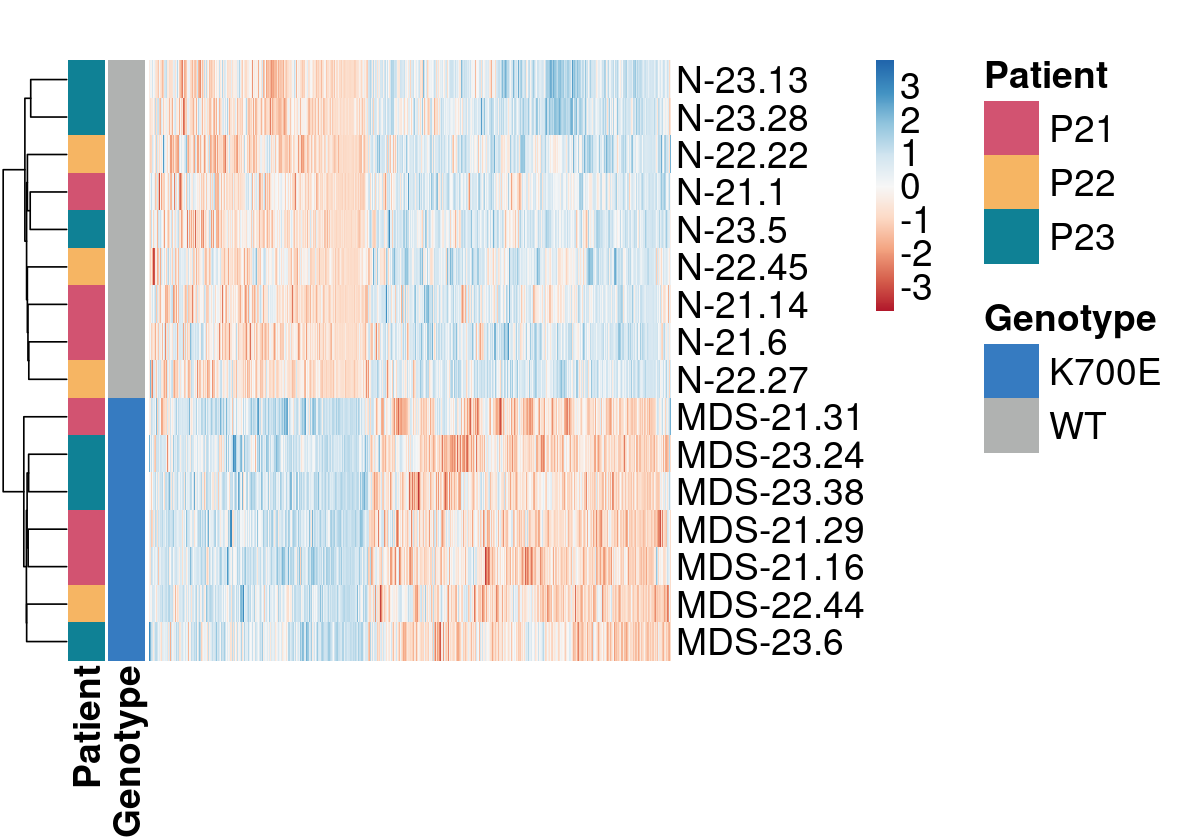

In [16]:
options(repr.plot.width=10, repr.plot.height=7)

colours2 = colorRampPalette(brewer.pal(9, "RdBu"))(255)

total_data <- total_data_scatter[,iPSC_lines]
data_pheat <- as.matrix(total_data)

colnames(data_pheat) <- lapply(colnames(data_pheat),function(x){strsplit(x,"\\.")[[1]][[2]]})
colnames(data_pheat) <- str_replace(colnames(data_pheat),"_",".")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS","MDS-")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"N","N-")

rownames(my_samples_col) <- str_replace(rownames(my_samples_col),"MDS-22.44b","MDS-22.44")
rownames(data_pheat) <- str_replace(rownames(data_pheat),"MDS-22.44b","MDS-22.44")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS-22.44b","MDS-22.44")

pheatmap(t(data_pheat),color=colours2, clustering_method = "average",annotation_colors = my_colour, annotation_row = my_samples_col,angle_col="90",
         scale = "column", show_rownames = TRUE, show_colnames = FALSE, cluster_rows = TRUE, cluster_cols = TRUE,treeheight_row = 35,treeheight_col = 0,
         fontsize=22,border_color="lightgrey",fontsize_col=22,main="", fontsize_row=22,cex=1) 

#### Examining gene overlap between DGE, differential transcript usage (DTU) and differential splicing (DAS)

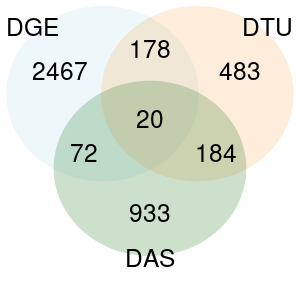

In [17]:
options(repr.plot.width=2.5, repr.plot.height=2.5) 

events <- c("A3SS","A5SS","MXE","RI","SE")

infile <- paste(results_directory, "MDS_Normal_dge_genes.txt",sep="")
dge_genes <- scan(infile,what="",sep="\n")
dge_genes <- as.vector(sapply(unique(dge_genes),function(x) {unique(annotation_map[which(annotation_map$GENEID==x),]$make_genename)})) 

infile <- paste(data_directory, "iPSC/dtu_genes.txt",sep="")
dtu_genes <- scan(infile,what="",sep="\n")

use <- list()
use[["DGE"]] <- dge_genes
use[["DTU"]] <- dtu_genes
use[["DAS"]] <- unique(total_data_scatter$gene)

ll <- combn(use,2,simplify=FALSE)
intersect_names <- combn(names(use), 2 ,FUN = paste0 , collapse = "_" , simplify = FALSE)
out <- lapply(ll, function(x) intersect( x[[1]] , x[[2]] ))
names(out) <- intersect_names                  
intersect_lengths <- lapply(out, length)
all_intersect <- Reduce(intersect,use)

venn.plot <- draw.triple.venn(area1 = length(use[[1]]), area2=length(use[[2]]), area3=length(use[[3]]),
                              n12=intersect_lengths[[1]], n13= intersect_lengths[[2]], 
                              n23 =intersect_lengths[[3]],n123=length(all_intersect),
                              category=str_replace(names(use),"_"," vs "),
                              fill = c("lightblue", "tan1", "darkgreen"),
                              lty = "blank",cex = 1.2,cat.cex = rep(1.2,3),
                              cat.dist = rep(0.025, 3),fontfamily = rep("Arial",7),
                              cat.fontfamily = rep("Arial",3),alpha = rep(0.2, 3),
                              cat.default.pos="outer", euler=TRUE,ind=FALSE)   

grid.arrange(gTree(children=venn.plot),bottom="")

#### Reading dataframe of tier 1 events and plotting their inclusion levels, types, associated transcripts

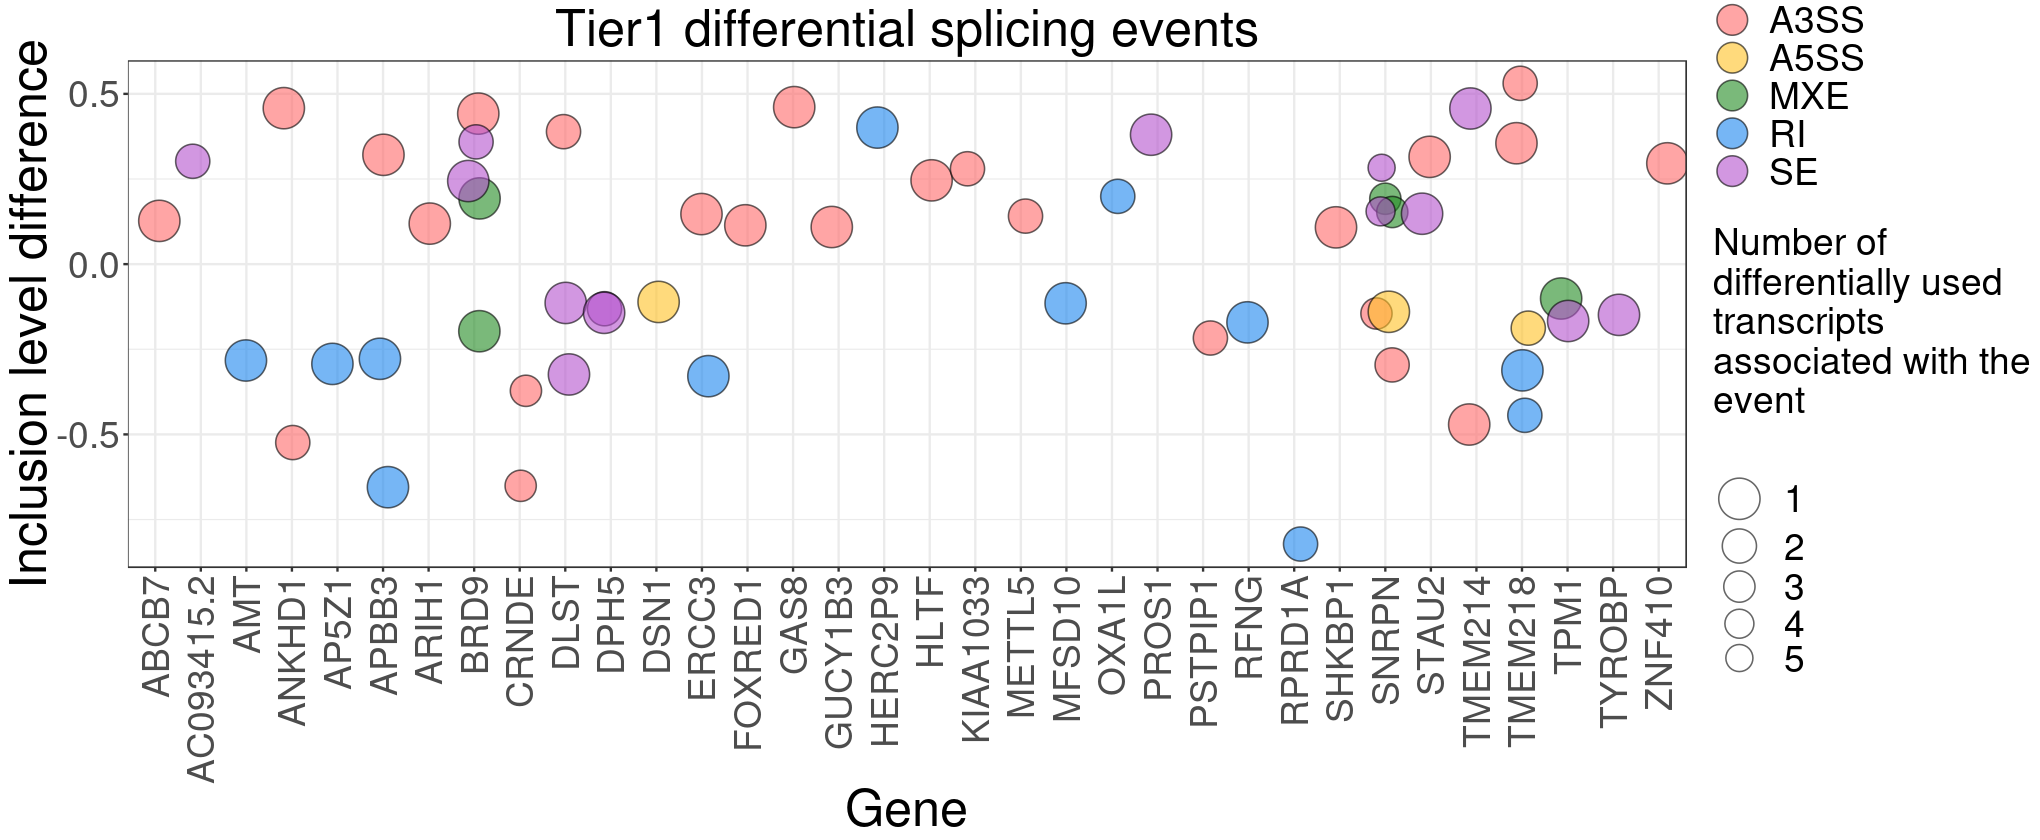

In [18]:
options(repr.plot.width=17, repr.plot.height=7) 

infile <- paste(data_directory,'iPSC/tier1_splicing_events.tsv',sep="")
tier1_splicing_events <- read.table(infile,header=TRUE,sep="\t",stringsAsFactors = F)

ggplot(tier1_splicing_events, aes(x=gene, y=sign_IncLevelDifference,fill=event_type,size=tr_count)) + geom_point(shape=21,alpha=0.6,position=position_jitter(w=0.2,h=0))+
        labs(title= "Tier1 differential splicing events",y="Inclusion level difference",x="Gene",fill="Event type",
             size=gsub('(.{1,20})(\\s|$)', '\\1\n', "Number of differentially used transcripts associated with the event")) +
        scale_fill_manual(values=mycols_events)+ theme_bw()+ theme(legend.text=element_text(size=22,family='Arial'),
                                                                   axis.text.x=element_text(size=22,angle=90,vjust = 0.5,
                                                                                            hjust=1,family='Arial'),
                                                                   axis.text.y=element_text(size=22,family='Arial'),
                                                                   legend.title=element_text(size=22,family='Arial'),
                                                                   axis.title=element_text(size=30,family='Arial'),
                                                                   plot.title=element_text(size=30,hjust=0.5,family='Arial')) +
        scale_size(range = c(max(tier1_splicing_events$tr_count)+6,min(tier1_splicing_events$tr_count)+6))+ 
        guides(size = guide_legend(reverse=FALSE),fill = guide_legend(override.aes = list(size=8)))

Volcano plot of expression of tier 1 genes

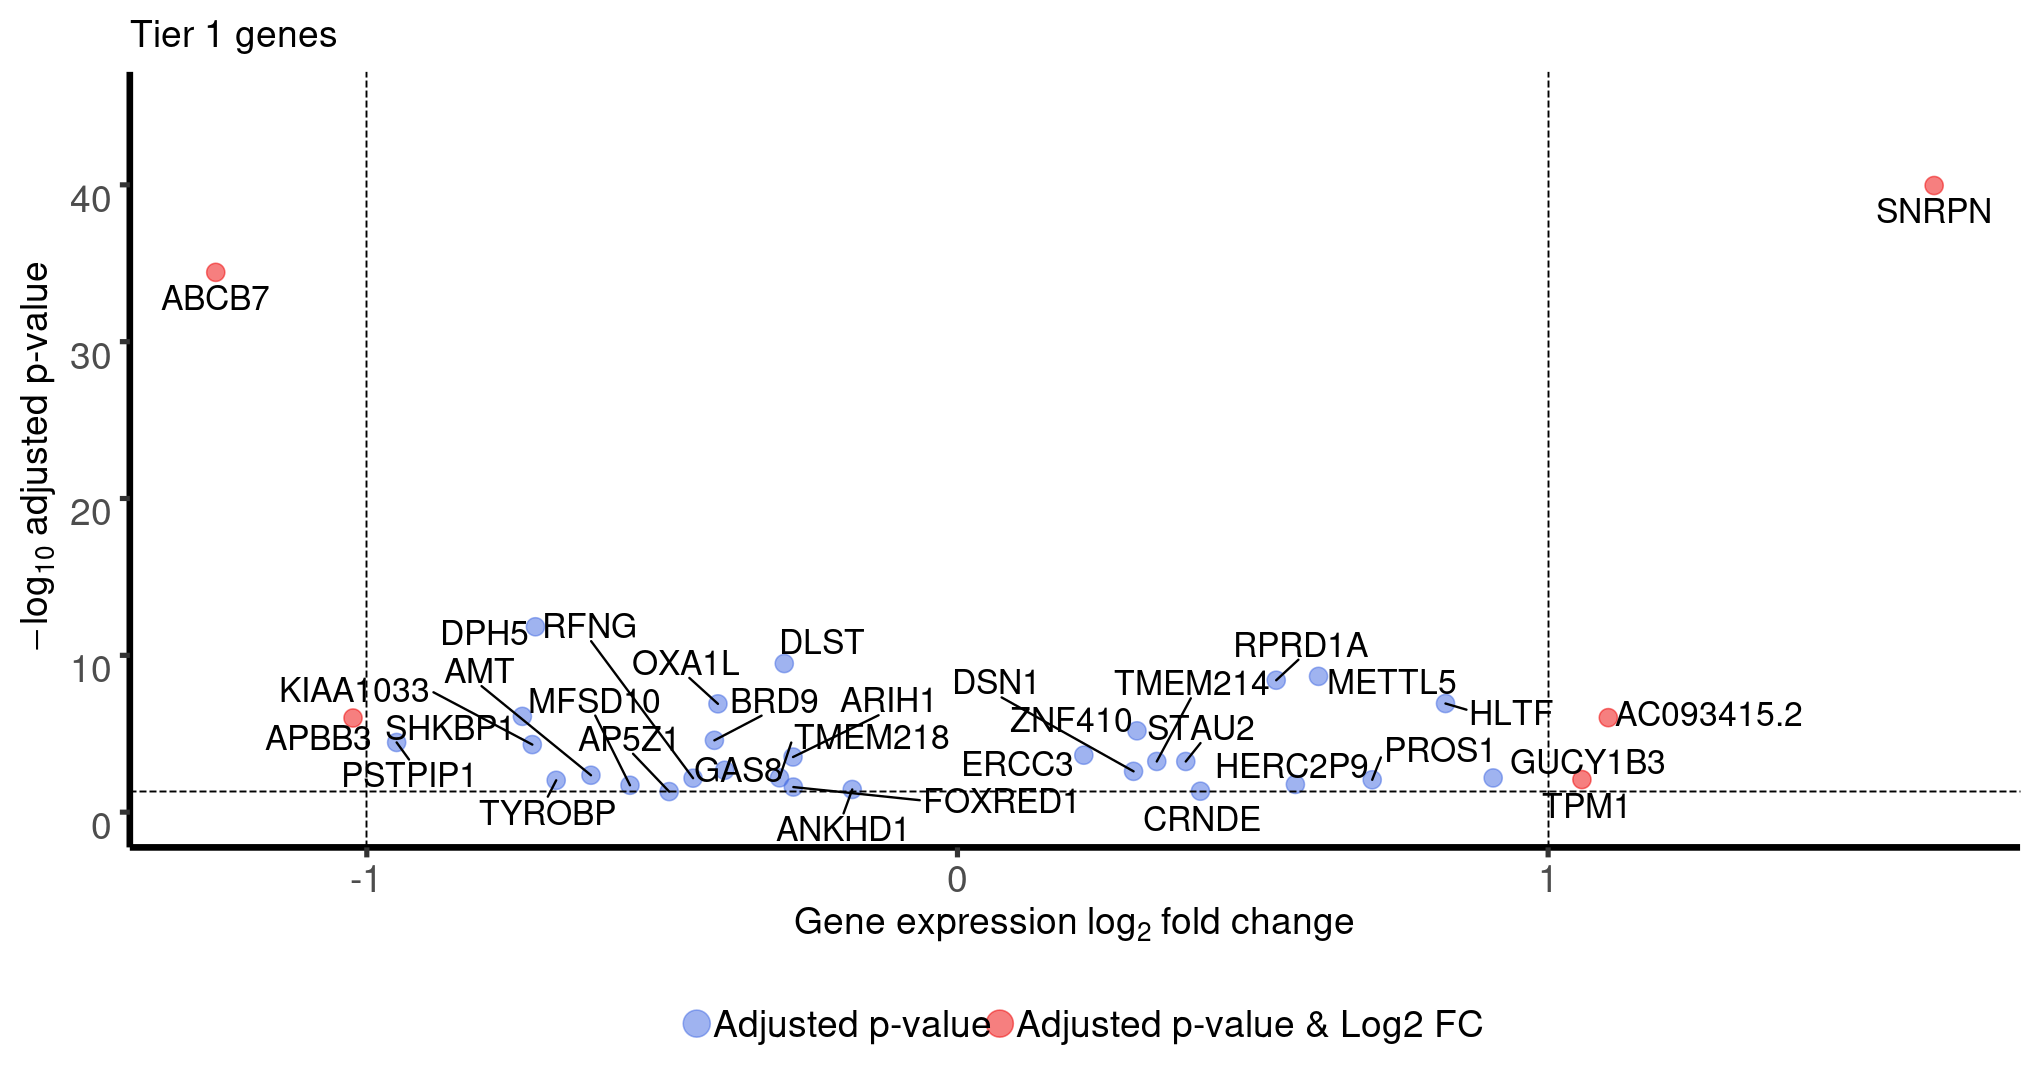

In [19]:
options(repr.plot.width=17, repr.plot.height=9) 

infile <- paste(results_directory,"MDS_Normal_dge_mat_before_filt.txt",sep="")
dge_mat_full <- read.table(infile,row.names=1,header=T)
rownames(dge_mat_full)<-as.vector(sapply(rownames(dge_mat_full),function(x) {unique(annotation_map[which(annotation_map$GENEID==x),]$make_genename)}))
toplot <- dge_mat_full[unique(tier1_splicing_events$gene),]

keyvals <- rep("grey30", nrow(toplot))
names(keyvals) <- rep("NS", nrow(toplot))

keyvals[which(toplot$padj < 0.05)] <- "royalblue"
names(keyvals)[which(toplot$padj < 0.05)] <- "Adjusted p-value"

keyvals[which(toplot$padj < 0.05 & abs(toplot$log2FoldChange)>1)] <- "red2"
names(keyvals)[which(toplot$padj < 0.05 & abs(toplot$log2FoldChange)>1)] <- "Adjusted p-value & Log2 FC"

EnhancedVolcano(toplot,lab = rownames(toplot),x = 'log2FoldChange',y = 'padj', gridlines.major = FALSE, gridlines.minor = FALSE,borderWidth = 1.4, axisLabSize = 22,titleLabSize=22,
                xlim=c(min(toplot$log2FoldChange,na.rm=TRUE),max(toplot$log2FoldChange,na.rm=TRUE)),xlab = bquote('Gene expression'~log[2]~'fold change'),ylab = bquote(~-log[10]~'adjusted p-value'),
                pCutoff = 0.05,FCcutoff = 1.0, colOverride=keyvals,selectLab=rownames(toplot),legendPosition = 'bottom',legendLabSize = 22,legendIconSize = 7.0,transcriptPointSize = 4.5,
                transcriptLabSize = 7,DrawConnectors=TRUE)+ ggtitle("Tier 1 genes") + theme(text=element_text(family='Arial'),plot.title = element_text(face = "plain",family='Arial'))

toplot$Expression <- 'up_stat_significant'
toplot[toplot$log2FoldChange<0,]$Expression <- 'down_stat_significant'
toplot$Expression_lfc <- 'below_1'
toplot[abs(toplot$log2FoldChange)>=1,]$Expression_lfc <- 'above_1'
toplot$gene <- rownames(toplot)

Distribution of tier 1 splicing events per event type

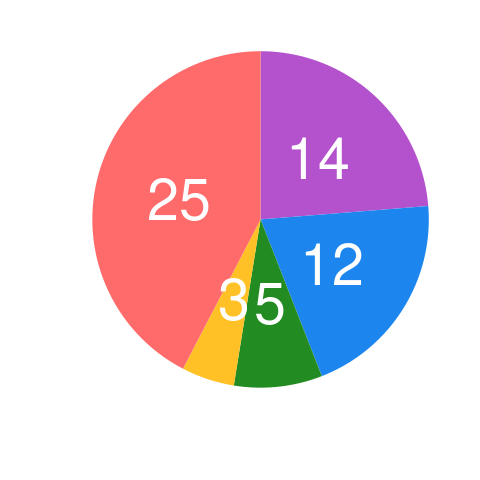

In [20]:
options(repr.plot.width=4, repr.plot.height=4) 

d2 <- tier1_splicing_events %>% 
      group_by(event_type) %>% 
      summarise(count = n()) %>% 
      mutate(perc = count/sum(count))

ggplot(d2, aes(x="",y=count, fill=event_type)) + geom_bar(stat="identity") + coord_polar("y", start=0) + theme_classic() +  
      geom_text(aes(y = count,label=count),family='Arial',color="white",size=12,position = position_stack(vjust = 0.5))+ scale_fill_manual(values=mycols_events)+
      theme(axis.line = element_blank(),axis.text = element_blank(),axis.ticks = element_blank(),legend.text=element_text(size=22,family='Arial'),axis.title=element_text(size=22,family='Arial'))+
      labs(fill="",x="",y="") + guides(fill=FALSE)

Distribution of differential splicing events per tier and event type

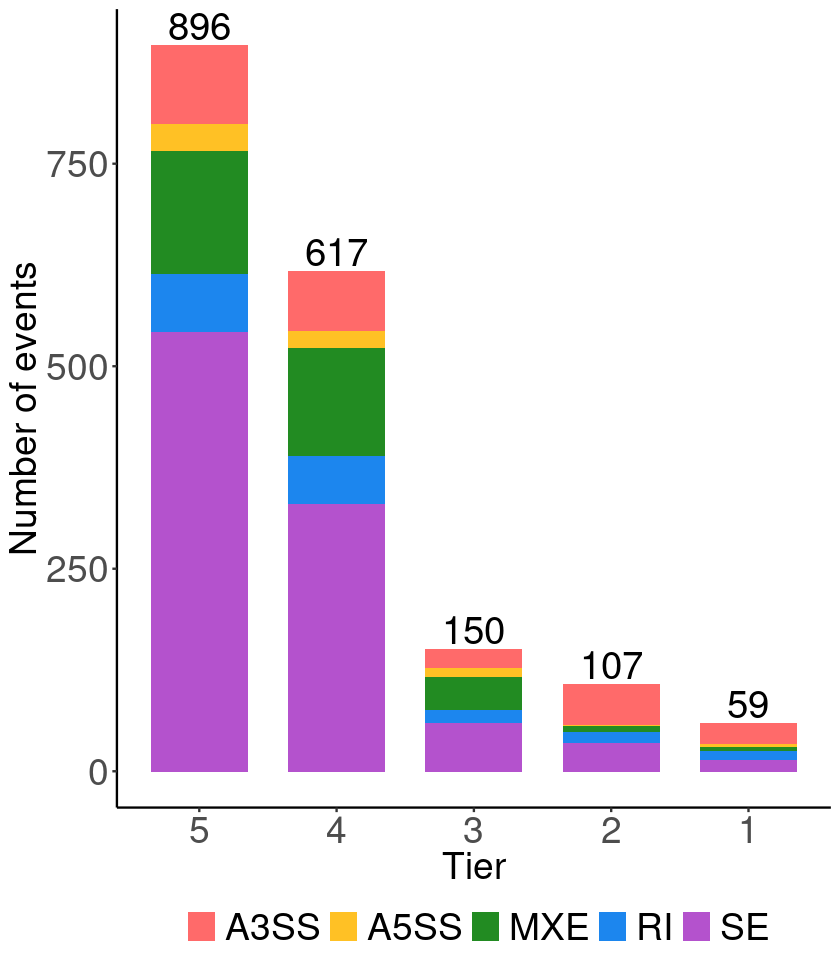

In [21]:
options(repr.plot.width=7, repr.plot.height=8) 

d2 <- total_data_scatter %>% 
      group_by(tier,event_type) %>% 
      summarise(count = n()) %>% 
      mutate(perc = count/sum(count))

d2$tier <- factor(d2$tier,levels = c("5","4","3","2","1"))
d3 = d2[,c("tier","count")] %>% group_by(tier)%>% summarise(sum = sum(count))  

ggplot(d2, aes(x = tier, y = count, fill = event_type)) + geom_bar(stat="identity", width = 0.7) + theme_classic() + scale_fill_manual(values=mycols_events)+
            theme(panel.grid.major.x = element_blank(),panel.grid.major.y = element_blank(),legend.position="bottom",
                  legend.text=element_text(size=22,family='Arial'),axis.text=element_text(size=22,family='Arial'),
                  axis.title=element_text(size=22,family='Arial'),plot.title=element_text(size=22,family='Arial')) +
            labs(x="Tier",y="Number of events",fill="") +
            geom_text(data=d3, aes(x = tier, y = sum, label=sum,fill=NULL),family='Arial',vjust=-0.2,size=8)

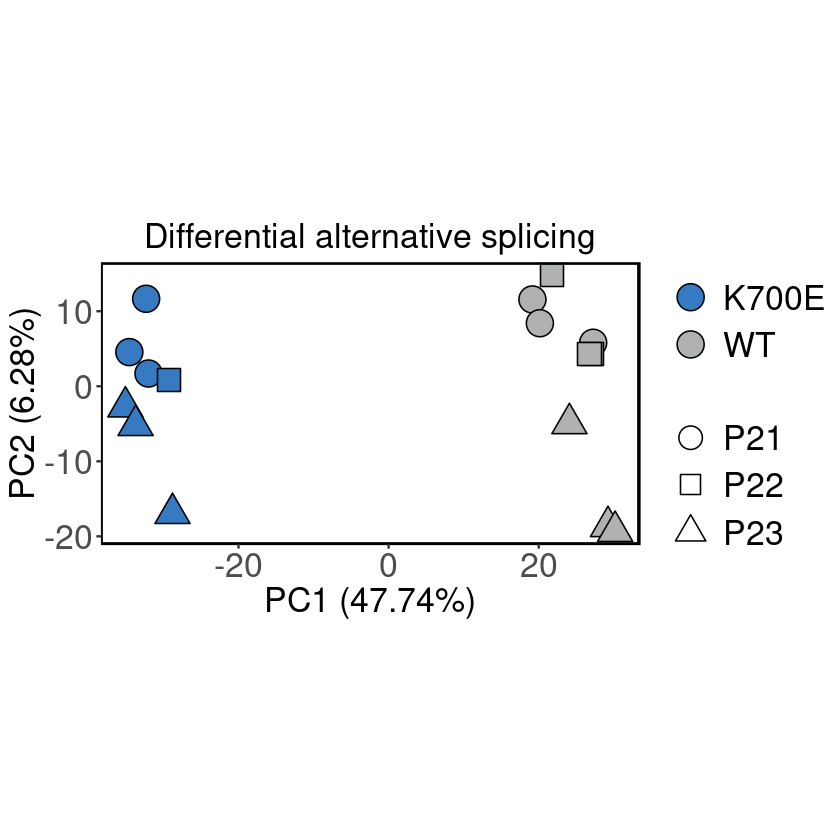

In [22]:
options(repr.plot.width=7, repr.plot.height=7)

temp <- as.data.frame(colData(dds),stringsAsFactors = F)

temp$condition_factor <- str_replace(temp$condition_factor,"Normal","WT")
temp$condition_factor <- str_replace(temp$condition_factor,"MDS","K700E")
temp$individ_factor <- as.character(temp$individ_factor)
category <- temp
category <- category[c(rownames(category[which(category$condition_factor=='K700E'),]),rownames(category[which(category$condition_factor=='WT'),])),]
category$individ_factor <- gsub("donor","P",category$individ_factor)

total_data.pca <- prcomp(t(total_data[,rownames(category)]), center = TRUE,scale. = TRUE)

autoplot(total_data.pca,scale=0,data=cbind(t(total_data[,rownames(category)]),category),fill="condition_factor",shape="individ_factor",size=7) + scale_fill_manual(values=c("#367BC1","#B0B2B1"))+
        scale_shape_manual(values=c(21, 22, 24))+ labs(shape="",fill="")+theme_bw() + ggtitle("Differential alternative splicing")+ 
        theme(legend.text=element_text(size=20,family="Arial"),axis.text=element_text(size=20,family="Arial"),
              legend.key.size = unit(1, "cm"), axis.title=element_text(size=20,family="Arial"),
              plot.title=element_text(size=20,hjust=0.5,family="Arial"),legend.spacing.y = unit(0.1, 'cm'),
              panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1)) +
        guides(fill = guide_legend(override.aes = list(shape = 21)),
               shape = guide_legend(override.aes = list(size = 6))) +
        coord_fixed()

#### Reading differential splicing results from Pellagatti et al.

In [56]:
infile<-paste(data_directory,"patient_samples/comparisons.txt",sep="") 
pairs<-read.table(infile, header=F,stringsAsFactors = F)
pairs
results <- list()
total_sub_isolate<-list()
sf_isolate_df <- list()
features <- tier1_splicing_events$coord

for (i in 1:dim(pairs)[1]){ #for each combination e.g. SF3B1-WT

    results[[i]] <- readRDS(paste(data_directory,"patient_samples/concat_res_",pairs[i,1],"_",pairs[i,2],".rds",sep=""))
    single_comb_list <- results[[i]]
    names(results)[i] <- paste(pairs[i,1],"_",pairs[i,2],sep="")
    sub_isolate_df <- list()
    
    collect_all <- c()
    
    for (j in 1:5){
    
        isolate_df <- single_comb_list[[j]]
        
        event<-names(single_comb_list)[j]
        isolate_df$coord<-do.call(paste, c(isolate_df, sep="_"))
    
        sub_isolate_df[[j]]<-isolate_df[which(isolate_df$coord %in% features),]
        names(sub_isolate_df)[j]<-event
        
        collect_all <- append(collect_all,isolate_df$coord)           
    }
    
    total_sub_isolate[[i]] <- sub_isolate_df
    names(total_sub_isolate)[i] <- names(results)[i]
    
    sf_isolate_df[[i]] <- collect_all
    names(sf_isolate_df)[i] <- names(results)[i]    
}

V1    V2  
1 SF3B1 SFWT
2 SF3B1 WT  
3 U2AF1 SFWT
4 U2AF1 WT  
5 SRSF2 SFWT
6 SRSF2 WT

#### Examining overlap of iPSC signature events with the differential splicing events from Pellagatti et al.  

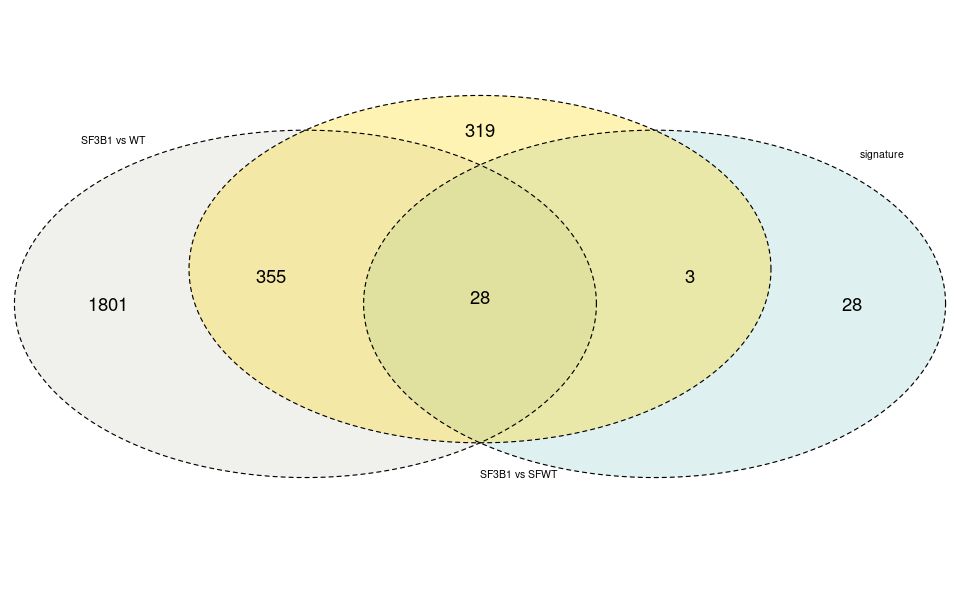

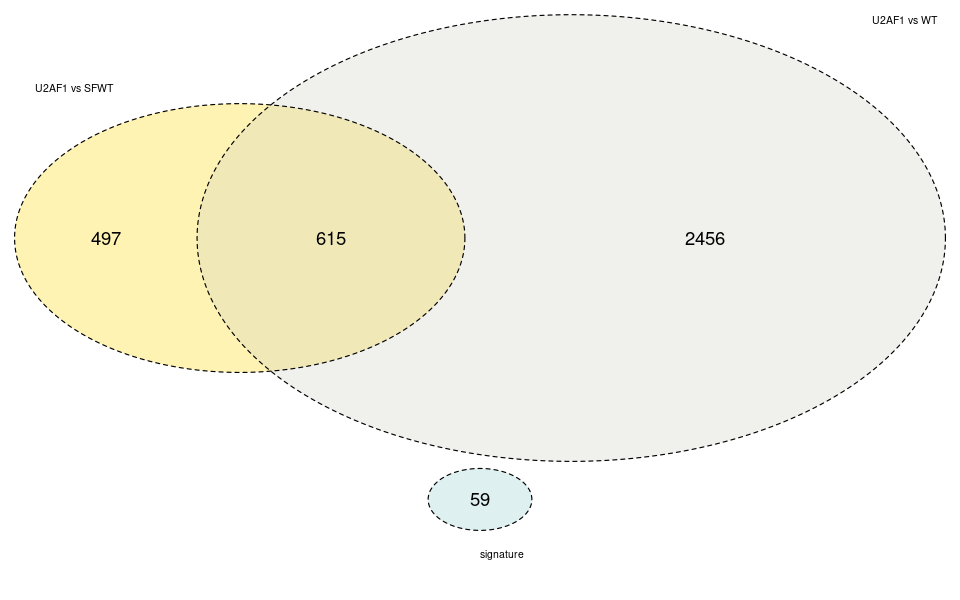

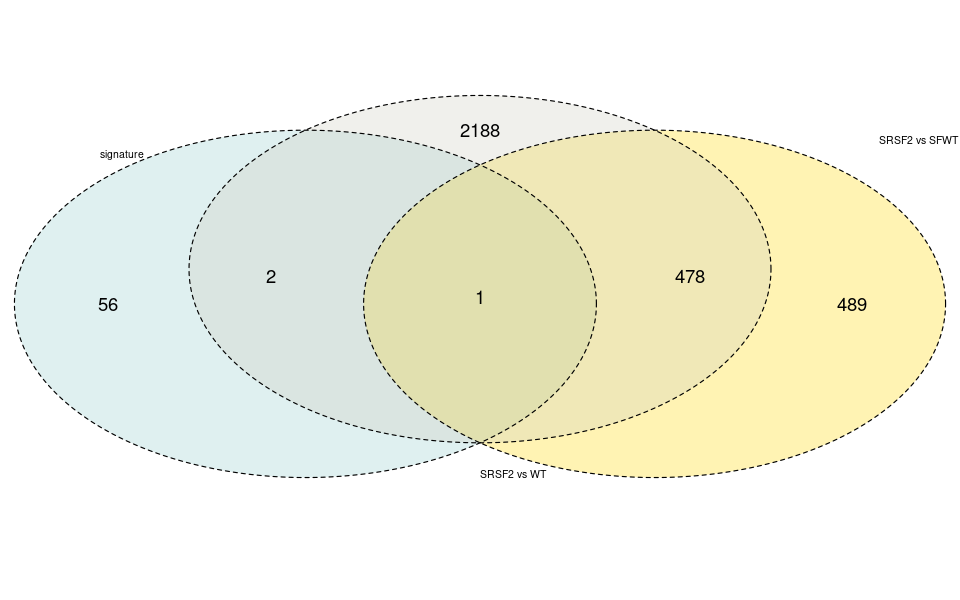

In [57]:
options(repr.plot.width=8, repr.plot.height=5) 

for (type in c(1,3,5)){

    feats_list<-list()

    name_set_SFWT<-names(sf_isolate_df)[type]
    name_set_WT<-names(sf_isolate_df)[type+1]
            
    feats_list[[name_set_SFWT]]<-sf_isolate_df[[name_set_SFWT]]
    feats_list[[name_set_WT]]<-sf_isolate_df[[name_set_WT]]
    feats_list[["signature"]]<-features
                      
    use<-feats_list
    ll<-combn(use,2,simplify=FALSE)
    intersect_names<- combn( names(use) , 2 , FUN = paste0 , collapse = "_" , simplify = FALSE )
    out <- lapply(ll, function(x) intersect( x[[1]] , x[[2]] ))
    names(out)<-intersect_names                  
    intersect_lengths<- lapply(out, length)
    all_intersect<- Reduce(intersect,use)

    venn.plot <- draw.triple.venn(area1 = length(use[[1]]), area2=length(use[[2]]), area3=length(use[[3]]), 
                                  n12=intersect_lengths[[1]], n13= intersect_lengths[[2]],
                                  n23 =intersect_lengths[[3]],n123=length(all_intersect),
                                  category=str_replace(names(use),"_"," vs "),
                                  fill = c("gold", "ivory3", "paleturquoise3"),
                                  cex = 0.9,cat.cex = rep(0.5,3),alpha = rep(0.3, 3),
                                  cat.fontfamily = rep("Arial",3),fontfamily = rep("Arial",7),
                                  cat.default.pos="outer",scaled = T,
                                  cat.just=list(c(0,0) , c(0,0) , c(0,0)),
                                  ind=FALSE,lty="dashed",lwd=c(0.7,0.7,0.7))
        
    g <- arrangeGrob(grid.arrange(gTree(children=venn.plot),bottom=""))
}    

#### Examining the presence of tier 1 iPSC events in the SF3B1 related differential splicing events of Pellagatti et al.  

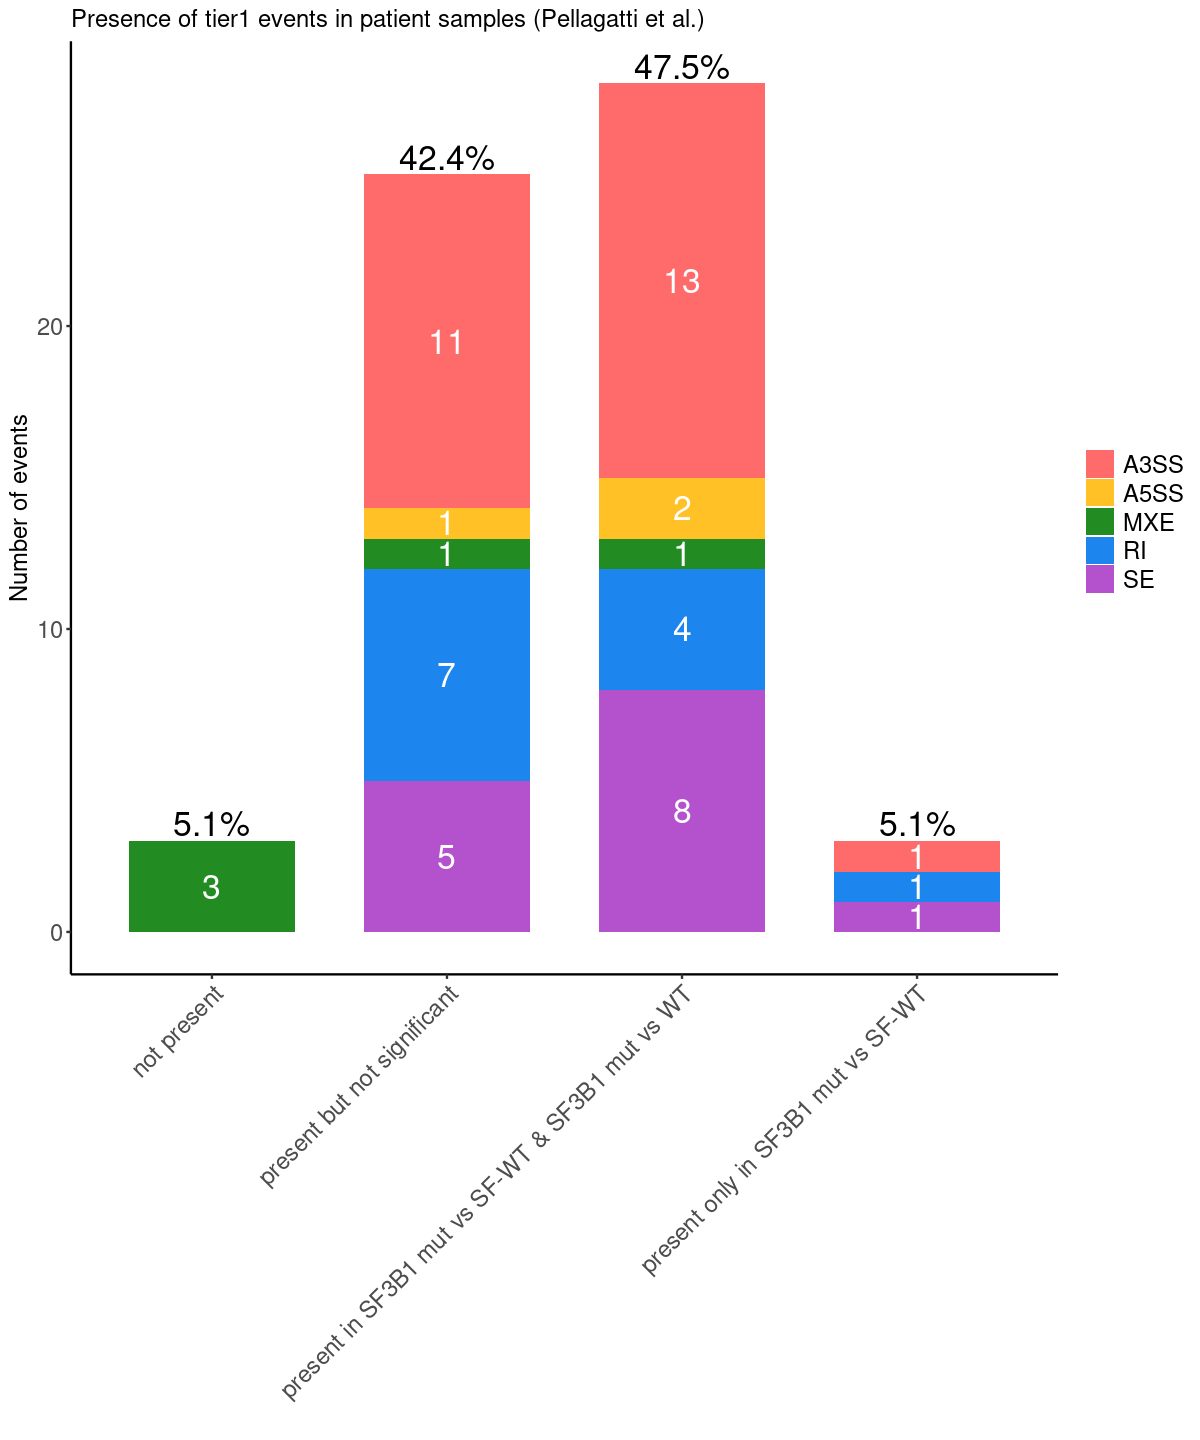

In [25]:
options(repr.plot.width=10, repr.plot.height=12) 

tier1_splicing_events$external <- "present but not significant"

for (type in c(1)){

    name_set_SFWT<-names(total_sub_isolate)[type]
    name_set_WT<-names(total_sub_isolate)[type+1]
    
    for (entry in 1:dim(tier1_splicing_events)[1]){
        
        event <- as.character(tier1_splicing_events[entry,"coord"])
        event_type <- as.character(tier1_splicing_events[entry,"event_type"])
        count<-0
        
        if (event %in% total_sub_isolate[[name_set_SFWT]][[event_type]]$coord){
            
            tier1_splicing_events[entry,"external"] <- "present only in SF3B1 mut vs SF-WT"
            count <- count+1
        }
        
        if (event %in% total_sub_isolate[[name_set_WT]][[event_type]]$coord){
            
            tier1_splicing_events[entry,"external"] <- "present only in SF3B1 mut vs WT"
            count <- count+1
        }
        
        if (count==2){
            
            tier1_splicing_events[entry,"external"] <- "present in SF3B1 mut vs SF-WT & SF3B1 mut vs WT"

        }
    }
    
    absent <- scan(paste(data_directory,"patient_samples/events_absent_inPel_bothWT_SFWT.txt",sep=""),what="", sep="\n")
    tier1_splicing_events[which(as.character(tier1_splicing_events$coord) %in% absent),"external"] <- "not present"
}

d2 <- tier1_splicing_events %>% 
    group_by(external, event_type) %>% 
    summarise(count = n()) 

d3 <- d2 %>% 
  group_by(external) %>% 
  summarize(total = sum(count))

d3$perc <- paste(as.character(round(100*d3$total / sum(d3$total),1)),"%",sep="")

ggplot(tier1_splicing_events, aes(x=factor(external), fill=event_type))+ geom_bar(width = 0.7, stat = "count")+ theme_classic()  +
        geom_text(stat='count', aes(label=..count..), color="white", position = position_stack(vjust = 0.5),size=7)+
        scale_fill_manual(values=mycols_events)+ geom_text(aes(label = perc,y=total),data=d3,vjust =-0.2,size=7,family="Arial")+
        ggtitle("Presence of tier1 events in patient samples (Pellagatti et al.)")+ theme(legend.position="right",
                                                                                          legend.text=element_text(size=14,family="Arial"),
                                                                                          plot.title=element_text(size=14,family="Arial"),
                                                                                          axis.title=element_text(size=14,family="Arial"),
                                                                                          axis.text.x=element_text(size=14,angle=45,hjust=1,family="Arial"),
                                                                                          axis.text.y=element_text(size=14,family="Arial"))+       
        labs(y = "Number of events", x = "",fill = "")

#### PCA plot of Pellagatti et al. samples based on the inclusion levels of the tier 1 splicing events 

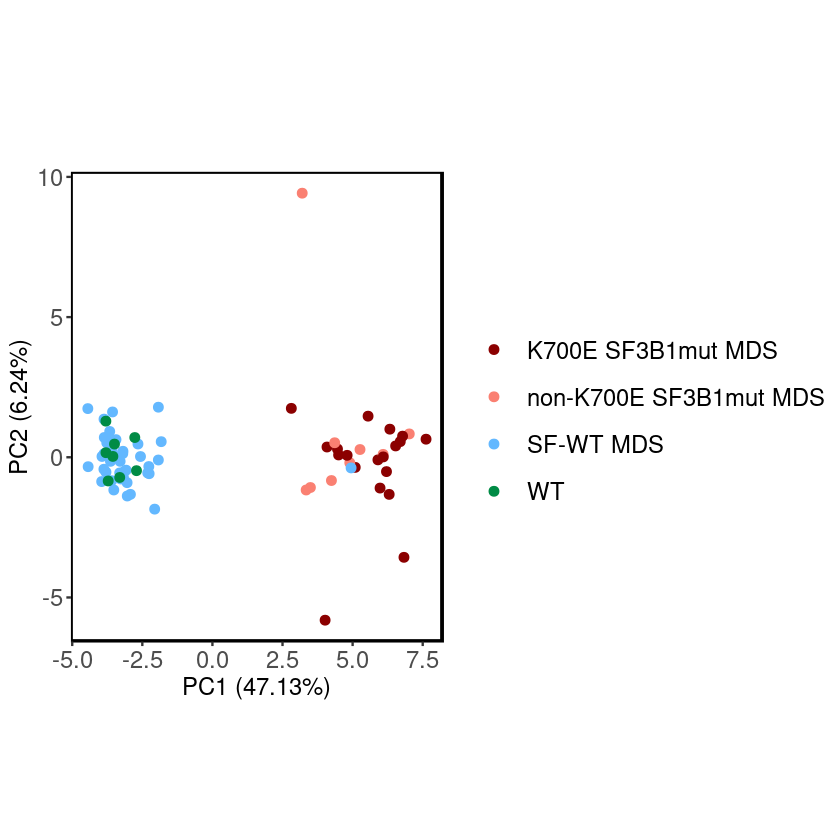

In [26]:
options(repr.plot.width=7, repr.plot.height=7)

infile <- paste(data_directory,'patient_samples/pca_map.txt',sep="")   
pca_df_pel <- read.table(infile,header=T,sep="\t", stringsAsFactors = F)

infile <- paste(data_directory,'patient_samples/samples_metadata.txt',sep="")   
pca_pel_meta <- read.table(infile,header=T,sep="\t", stringsAsFactors = F)

total_data.pca <- prcomp(t(pca_df_pel), center = TRUE,scale. = TRUE)

mycol <- c("darkred","salmon","steelblue1","springgreen4")

autoplot(total_data.pca,scale=0,x=1,y=2,data=cbind(t(pca_df_pel),pca_pel_meta),colour="hotspot",size=2) + scale_colour_manual(values = mycol,labels = c("K700E SF3B1mut MDS",
                                                                                                                                                "non-K700E SF3B1mut MDS",
                                                                                                                                                "SF-WT MDS", "WT"))+ 
        ggtitle("")+ theme_bw() + theme(legend.position="right",legend.text=element_text(size=14,family="Arial"),axis.text=element_text(size=14,family="Arial"),
                                        legend.key.size = unit(1, "cm"), panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
                                        panel.border = element_rect(colour = "black", fill=NA, size=1),axis.title=element_text(size=14,family="Arial"),
                                        plot.title=element_text(face="plain",size=14,hjust=0.5,family="Arial")) +
        labs(colour="") + guides(shape = guide_legend(override.aes = list(size = 6))) + coord_fixed()


#### Detailed heatmap of tier 1 iPSC events 

Preparing metadata of splicing events and annotations

In [27]:
my_event_col <- tier1_splicing_events[,c('gene','event_type','coord','assoc_txs_dtu_up_biotype','assoc_txs_dtu_down_biotype','external','naming')]
colnames(my_event_col) <- c('gene','Event','coord','Tx_up_biotype','Tx_down_biotype','In_Pellagatti_et_al','naming')
my_event_col$In_Pellagatti_et_al <- gsub(" ","_",my_event_col$In_Pellagatti_et_al)
my_event_col$In_Pellagatti_et_al <- gsub("&","and",my_event_col$In_Pellagatti_et_al)
my_event_col$In_Pellagatti_et_al <- gsub("-","",my_event_col$In_Pellagatti_et_al)
my_event_col[which(my_event_col$Tx_up_biotype==""),"Tx_up_biotype"]="no_upregulated_tx"
my_event_col[which(my_event_col$Tx_down_biotype==""),"Tx_down_biotype"]="no_downregulated_tx"
my_event_col[which(my_event_col$Tx_up_biotype=="nonsense_mediated_decay&nonsense_mediated_decay"),"Tx_up_biotype"]="nonsense_mediated_decay" # handle it the same as NMD

In [28]:
my_event_col <- left_join(my_event_col,toplot[,c("gene","Expression","Expression_lfc")],by = "gene")

In [29]:
types <- sapply(my_event_col$Tx_down_biotype, function(y){unique(strsplit(y,"&")[[1]])})
indexN <- which(sapply(types,function(y){length(unique(y))})!=1)
indexY <- which(sapply(types,function(y){length(unique(y))})==1)
names(indexY) <- sapply(names(indexY), function(y){strsplit(y,"&")[[1]][[1]]})
names(indexN) <- sapply(types[indexN],function(y){paste(sort(unlist(y)),collapse=".")})
indexN
my_event_col[indexY,]$Tx_down_biotype <- names(indexY)
my_event_col[indexN,]$Tx_down_biotype <- names(indexN)

types <- sapply(my_event_col$Tx_up_biotype, function(y){unique(strsplit(y,"&")[[1]])})
indexN <- which(sapply(types,function(y){length(unique(y))})!=1)
indexY <- which(sapply(types,function(y){length(unique(y))})==1)
names(indexY) <- sapply(names(indexY), function(y){strsplit(y,"&")[[1]][[1]]})
names(indexN) <- sapply(types[indexN],function(y){paste(sort(unlist(y)),collapse=".")})
indexN
my_event_col[indexY,]$Tx_up_biotype <- names(indexY)
my_event_col[indexN,]$Tx_up_biotype <- names(indexN)

named integer(0)

named integer(0)

Preparing meatadata for samples 

In [30]:
my_sample_col <- as.data.frame(colData(dds))[,c('condition_factor'),drop=F]
colnames(my_sample_col) <- 'Genotype'
my_sample_col$Genotype <- as.character(my_sample_col$Genotype)

rownames(my_sample_col) <- lapply(rownames(my_sample_col),function(x){strsplit(x,"\\.")[[1]][[2]]})
rownames(my_sample_col) <- str_replace(rownames(my_sample_col),"_",".")
rownames(my_sample_col) <- str_replace(rownames(my_sample_col),"MDS","MDS-")
rownames(my_sample_col) <- str_replace(rownames(my_sample_col),"N","N-")

my_sample_col$Genotype <- str_replace(my_sample_col$Genotype,"MDS","K700E")
my_sample_col$Genotype <- str_replace(my_sample_col$Genotype,"Normal","WT")

In [31]:
my_colour = list(
     Event = c(A3SS = 'indianred1', A5SS = 'goldenrod1', MXE = "forestgreen", RI = "dodgerblue2", SE = "mediumorchid3"),
     Genotype = c(K700E = "#367BC1", WT = "#B0B2B1"),    
     In_Pellagatti_et_al = c(not_present="tan1",present_but_not_significant="burlywood",present_only_in_SF3B1_mut_vs_SFWT="midnightblue",present_in_SF3B1_mut_vs_SFWT_and_SF3B1_mut_vs_WT="mediumseagreen"), 
     Tx_up_biotype=c(no_upregulated_tx="white",lincRNA="darksalmon",nonsense_mediated_decay="deeppink4",processed_transcript="thistle",protein_coding="darkcyan",retained_intron="azure3",
                     antisense="orangered"),
     Tx_down_biotype=c(no_downregulated_tx="white",lincRNA="darksalmon",nonsense_mediated_decay="deeppink4",processed_transcript="thistle",protein_coding="darkcyan",retained_intron="azure3",
                      antisense="orangered"),
     Expression=c(up_stat_significant="darkgoldenrod2",down_stat_significant="tan4"),
     Expression_lfc=c(below_1="lightpink1",above_1="chartreuse1")
)

labels_row <- my_event_col$naming
labels_row <- str_replace(labels_row,"\\.","-")
labels_row <- str_replace(labels_row,"AC093415-2","AC093415.2")

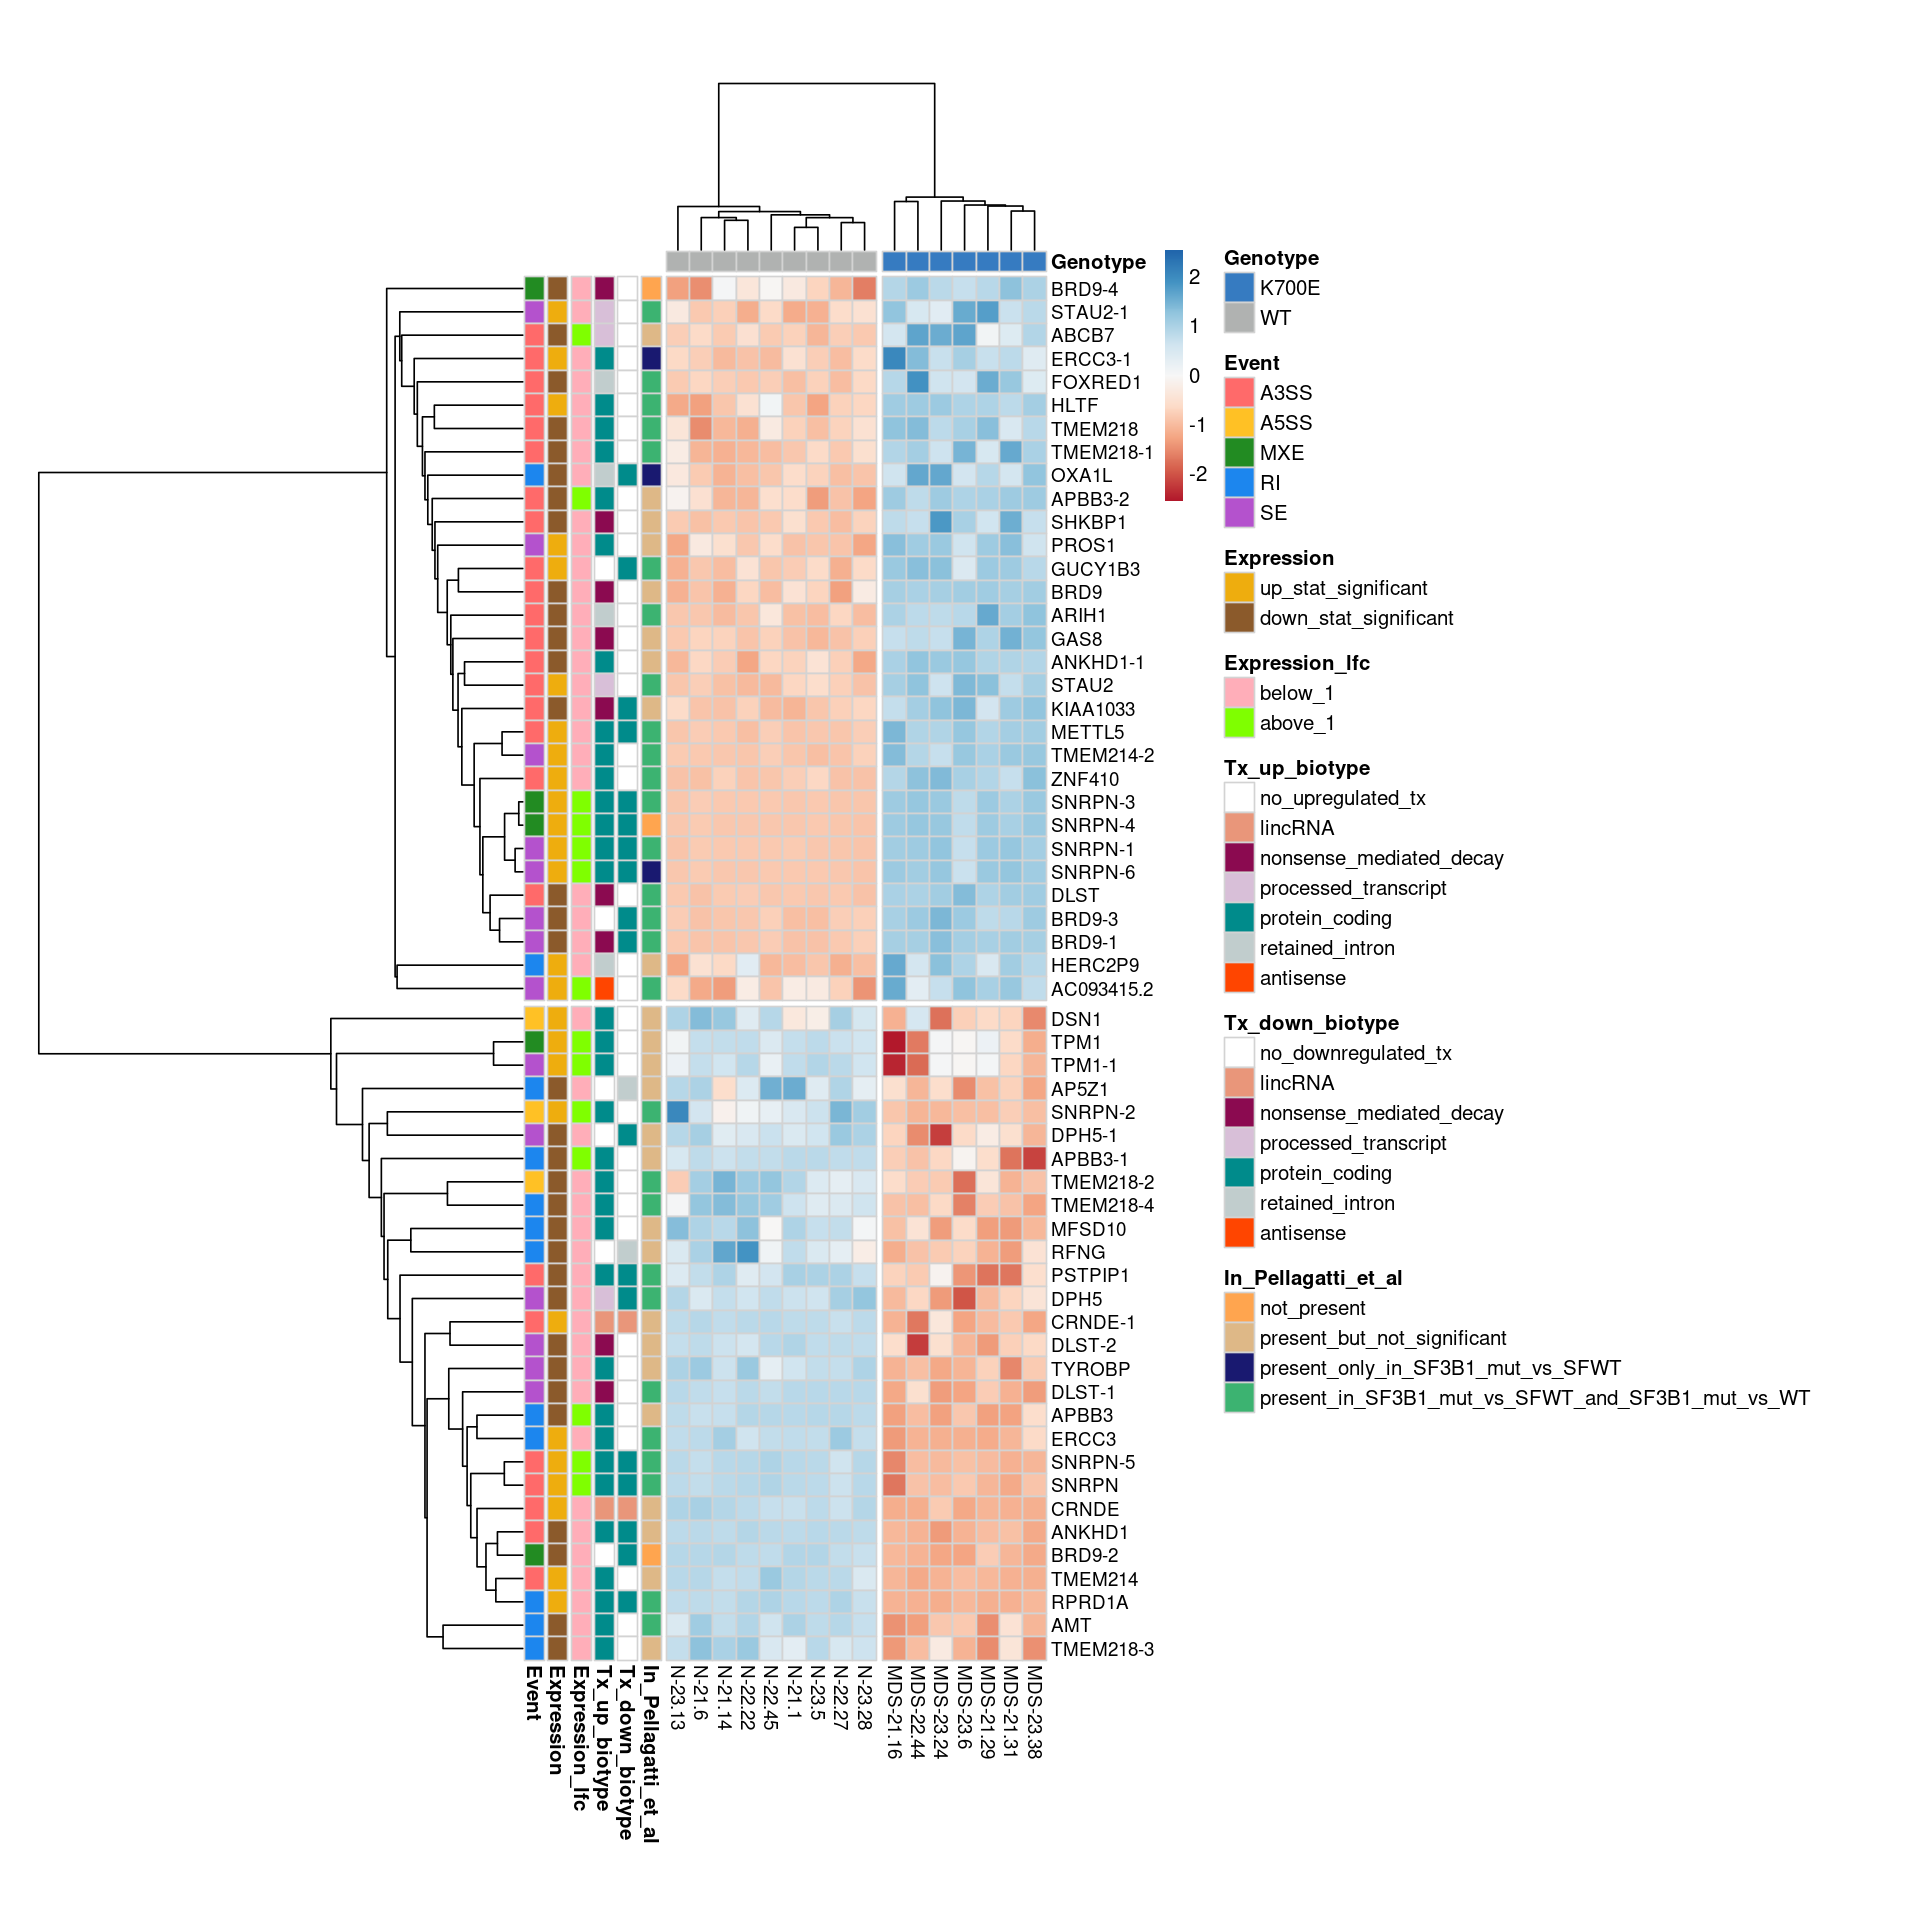

In [32]:
options(repr.plot.width=16, repr.plot.height=16) 

data_pheat<-as.matrix(total_data[my_event_col$coord,])

colnames(data_pheat) <- lapply(colnames(data_pheat),function(x){strsplit(x,"\\.")[[1]][[2]]})
colnames(data_pheat) <- str_replace(colnames(data_pheat),"_",".")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS","MDS-")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"N","N-")

rownames(my_sample_col) <- str_replace(rownames(my_sample_col),"MDS-22.44b","MDS-22.44")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS-22.44b","MDS-22.44")
rownames(my_event_col) <- my_event_col$coord

my_sample_col <- my_sample_col[c(rownames(my_sample_col[which(my_sample_col$Genotype=='K700E'),,drop=F]),rownames(my_sample_col[which(my_sample_col$Genotype=='WT'),,drop=F])),,drop=F]
data_pheat <- data_pheat[,rownames(my_sample_col)]

pheatmap(data_pheat,color=colours2,clustering_method = "average",scale = "row",annotation_colors = my_colour,
         annotation_row = my_event_col[,rev(c("Event","Expression","Expression_lfc","Tx_up_biotype",
                                              "Tx_down_biotype","In_Pellagatti_et_al"))],
         cellheight=14, annotation_legend=TRUE, cellwidth=14, labels_row=labels_row, annotation_col = my_sample_col,
         cutree_rows = 2,cutree_cols = 2,fontsize=12,border_color="lightgrey",fontsize_col=11,fontsize_row=11,
         cex=1,treeheight_col = 100,treeheight_row = 300)

## ATAC-seq Analysis

#### Reading chromatin accessibility object of peaks and producing PCA plots and heatmap based on peak counts

In [33]:
load_atacDDS <- paste(data_directory,"iPSC/ATAC_dds.rds",sep="")
atacDDS <- readRDS(load_atacDDS)

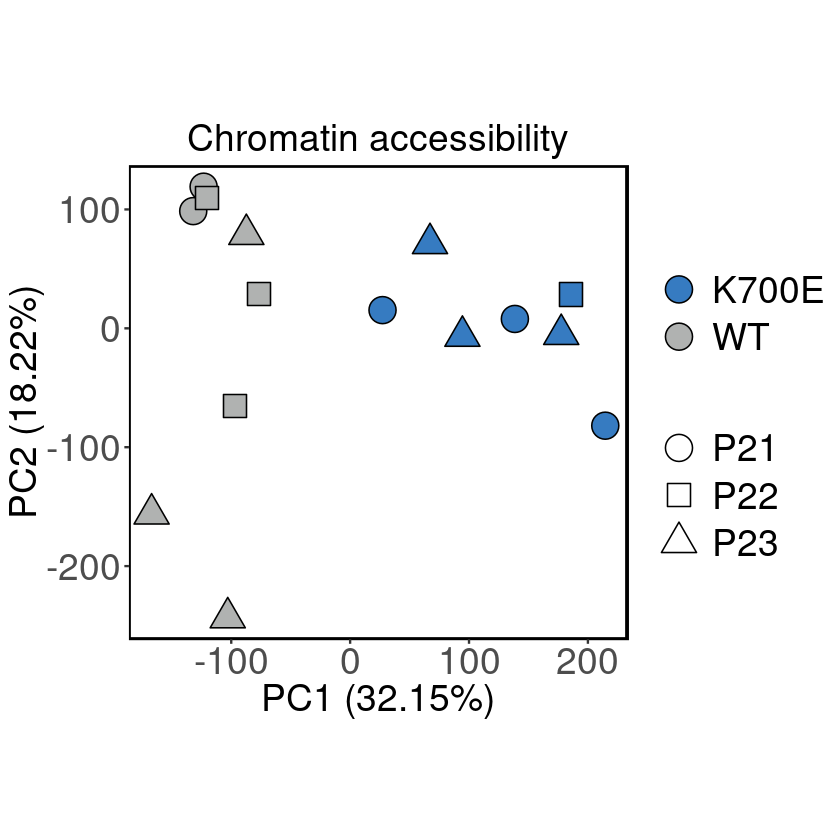

In [34]:
options(repr.plot.width=7, repr.plot.height=7)

vstnorm <- vst(atacDDS, blind=FALSE)
counts_vst<-as.matrix(assay(vstnorm))

counts_vst.pca <- prcomp(t(counts_vst), center = TRUE,scale. = TRUE)

category <- sapply(rownames(colData(atacDDS)), function(y){paste(strsplit(y,"_")[[1]][c(1,2)],collapse="_")})
category <- gsub("_",".",category)
cat <- gsub("MDS","K700E",category)
cat <- gsub("Normal","WT",cat)

category<-data.frame("category"=as.vector(cat),stringsAsFactors = F)
category2<-data.frame("type"=as.vector(sapply(cat,function(x) {strsplit(x,"\\.")[[1]][2]})),stringsAsFactors = F)
category3<-data.frame("donor"=as.vector(sapply(cat,function(x) {strsplit(x,"\\.")[[1]][1]})),stringsAsFactors = F)
cat <- cbind(category2,category3)
cat$donor <- gsub("donor","P",cat$donor)

autoplot(counts_vst.pca,scale=0,data=cbind(t(counts_vst),cat),fill="type",shape="donor",size=7,loadings = FALSE,label=FALSE) + theme_bw() +
        scale_fill_manual(values=c("#367BC1","#B0B2B1"))+ scale_shape_manual(values=c(21, 22, 24)) + ggtitle("Chromatin accessibility")+
        theme(legend.position="right",legend.text=element_text(size=22,family="Arial"),axis.text=element_text(size=22,family="Arial"),
              panel.grid.major.x = element_blank(),panel.grid.major.y = element_blank(), panel.grid.minor = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1), legend.key.size = unit(1, "cm"),
              axis.title=element_text(size=22,family="Arial"),plot.title=element_text(face="plain",size=22,hjust=0.5,family="Arial"))+
        guides(fill = guide_legend(override.aes = list(shape = 21)),shape = guide_legend(override.aes = list(size = 7)))+
        labs(fill="",shape="") + coord_fixed()

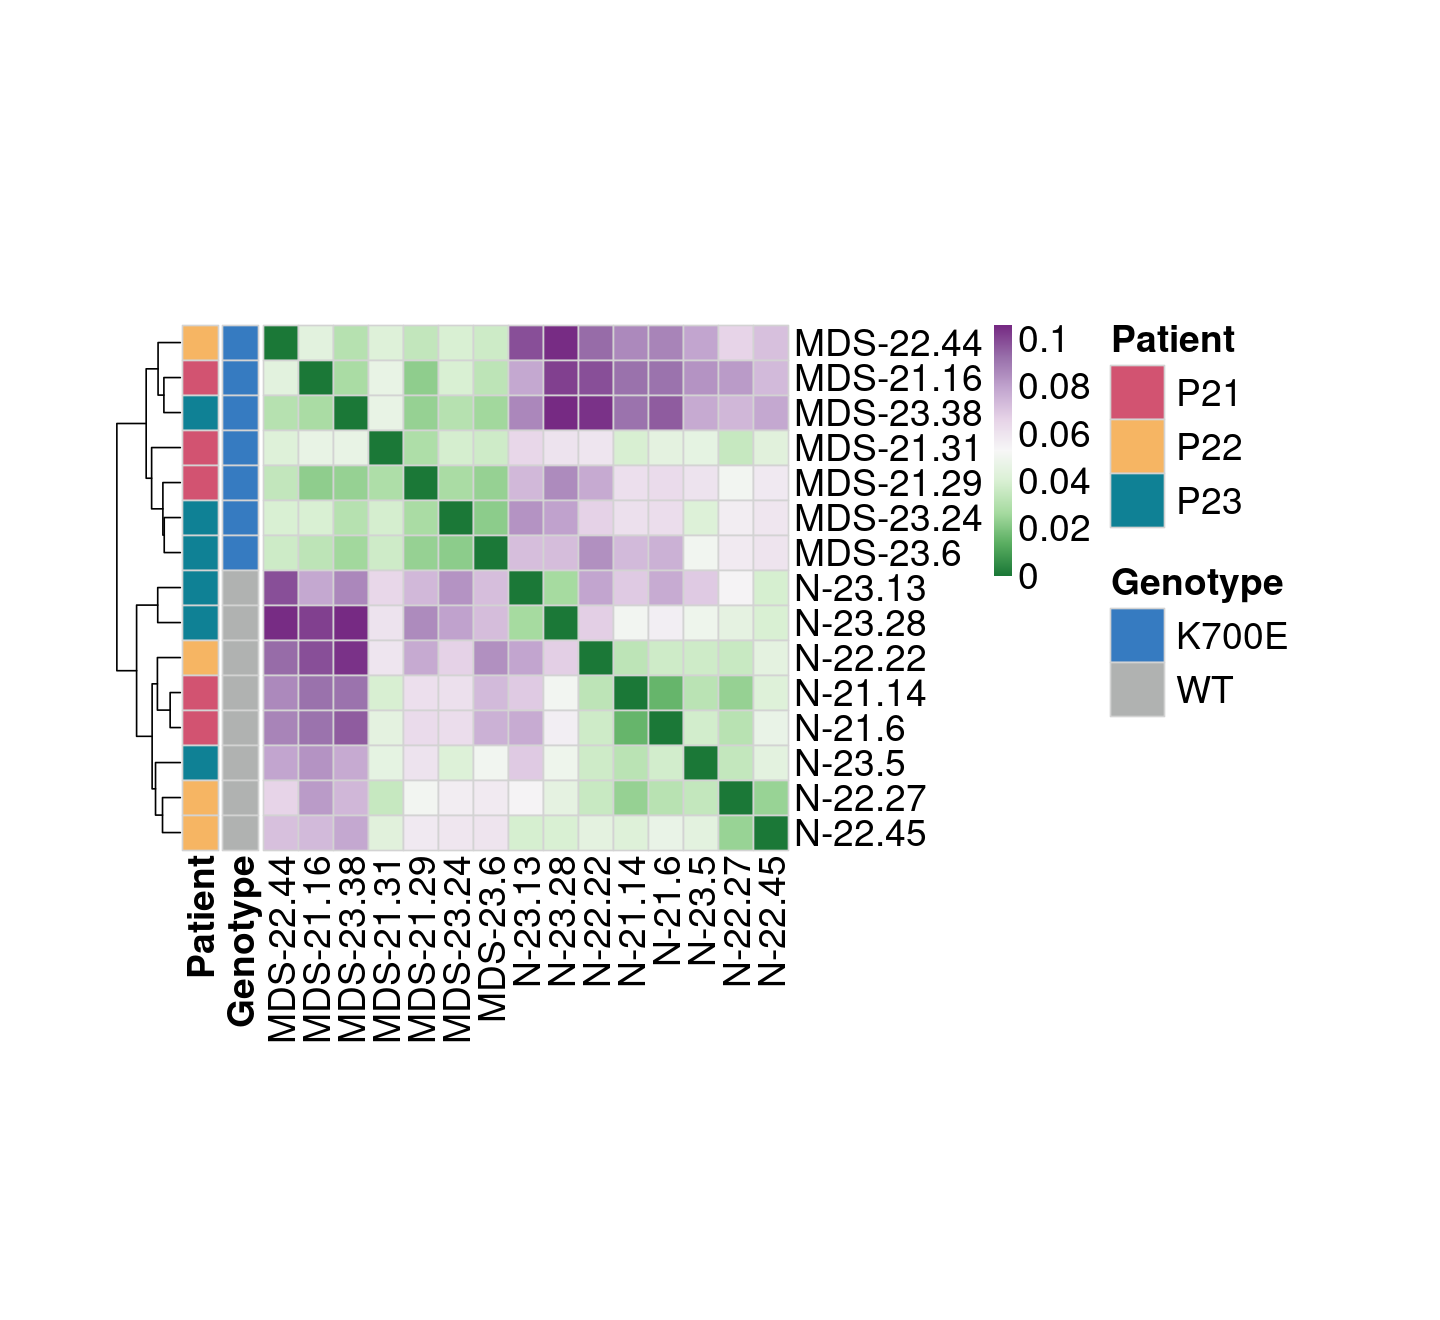

In [35]:
options(repr.plot.width=12, repr.plot.height=11)

testcorpearpeak <- 1 - cor(assay(vstnorm),method="pearson")
testsampleDistMatrixpeak <- as.matrix(testcorpearpeak)

colours = colorRampPalette(rev(brewer.pal(9, "PRGn")))(255)

data_pheat <- testsampleDistMatrixpeak

colnames(data_pheat) <- lapply(colnames(data_pheat),function(x){paste(strsplit(x,"_")[[1]][[2]],strsplit(x,"_")[[1]][[3]],strsplit(x,"_")[[1]][[4]],sep=".")})
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS.sample","MDS-")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"Normal.sample","N-")
rownames(data_pheat) <- colnames(data_pheat)

my_samples_col <- sapply(colnames(data_pheat),function(x){strsplit(x,"-")[[1]][[1]]})
my_samples_col <- str_replace(my_samples_col,"MDS","K700E")
my_samples_col <- str_replace(my_samples_col,"N","WT")

names(my_samples_col) <- colnames(data_pheat)
my_samples_col <- as.data.frame(my_samples_col,stringsAsFactors = F)
colnames(my_samples_col) <- "Genotype"

my_samples_col$Patient <- rownames(my_samples_col)
my_samples_col$Patient <- sapply(rownames(my_samples_col),function(x){strsplit(x,"-")[[1]][[2]]})
my_samples_col$Patient <- sapply(my_samples_col$Patient,function(x){strsplit(x,"\\.")[[1]][[1]]})
my_samples_col$Patient <- paste("P",my_samples_col$Patient,sep="")

rownames(my_samples_col) <- str_replace(rownames(my_samples_col),"MDS-22.44b","MDS-22.44")
rownames(data_pheat) <- str_replace(rownames(data_pheat),"MDS-22.44b","MDS-22.44")
colnames(data_pheat) <- str_replace(colnames(data_pheat),"MDS-22.44b","MDS-22.44")

my_colour = list(Genotype = c(K700E = "#367BC1", WT = "#B0B2B1"),
                Patient = c(P21 = "#D25371",P22="#F6B563",P23="#0F8195"))
 
pheatmap(data_pheat,color=colours,clustering_method = "average",annotation_colors = my_colour, show_rownames = TRUE, show_colnames = TRUE, angle_col="90",
         cellheight=21,cellwidth=21,cutree_rows = 1,cutree_cols = 1,fontsize=22,border_color="lightgrey",fontsize_col=22,fontface="plain", fontfamily = 'Arial',
         fontsize_row=22,cex=1,treeheight_col = 0,treeheight_row = 35,annotation_row = my_samples_col,main="",annotation_legend=TRUE)

#### Performing differential accessibility analysis and identifying differentially accessible peaks

In [36]:
infile <- paste(data_directory,'iPSC/peakAtlas_annotation.tsv',sep="")   
peak_annotation_map <- read.table(infile,header=T,sep="\t", stringsAsFactors = F)

query <- "MDS"
ref <- "Normal"
    
nms <- paste(query,"_",ref,sep="")
    
project_res <- results(atacDDS,contrast=c("condition_factor",query,ref),alpha=0.05)
project_res <- lfcShrink(atacDDS, contrast=c("condition_factor",query,ref), res=project_res)

project_res_sort <- project_res[order(project_res$padj), ]
    
dif_outfile<-paste(results_directory,nms,"_dacc_mat_before_filt.txt",sep="")
write.table(as.data.frame(project_res_sort), file=dif_outfile, row.names=T, col.names=T, sep="\t", quote = FALSE)
    
index<-project_res_sort$padj<0.05
index[is.na(index)]<-FALSE
project_diff_acc <- project_res_sort[index,]
        
project_diff_acc <- project_diff_acc[abs(project_diff_acc$log2FoldChange)>=1.0,] 
    
project_region_names <- rownames(project_diff_acc)
        
dif_outfile <- paste(results_directory,nms,"_dacc_regions.txt",sep="")
write.table(as.data.frame(project_region_names), file=dif_outfile, row.names=F, col.names=F, sep="\t", quote = FALSE)

toobtain <- peak_annotation_map$peakID %in% project_region_names
gr_object <- GRanges(peak_annotation_map[toobtain,])

dif_outfile <- paste(results_directory,nms,"_dacc_sortchr.txt",sep="")
write.table(as.data.frame(project_diff_acc[gr_object$peakID,]), file=dif_outfile, row.names=T, col.names=T, sep="\t", quote = FALSE)    

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).
additional priors are available via the 'type' argument, see ?lfcShrink for details


Volcano plot for chromatin accessibility

Warning message:
“Removed 4 rows containing missing values (geom_point).”

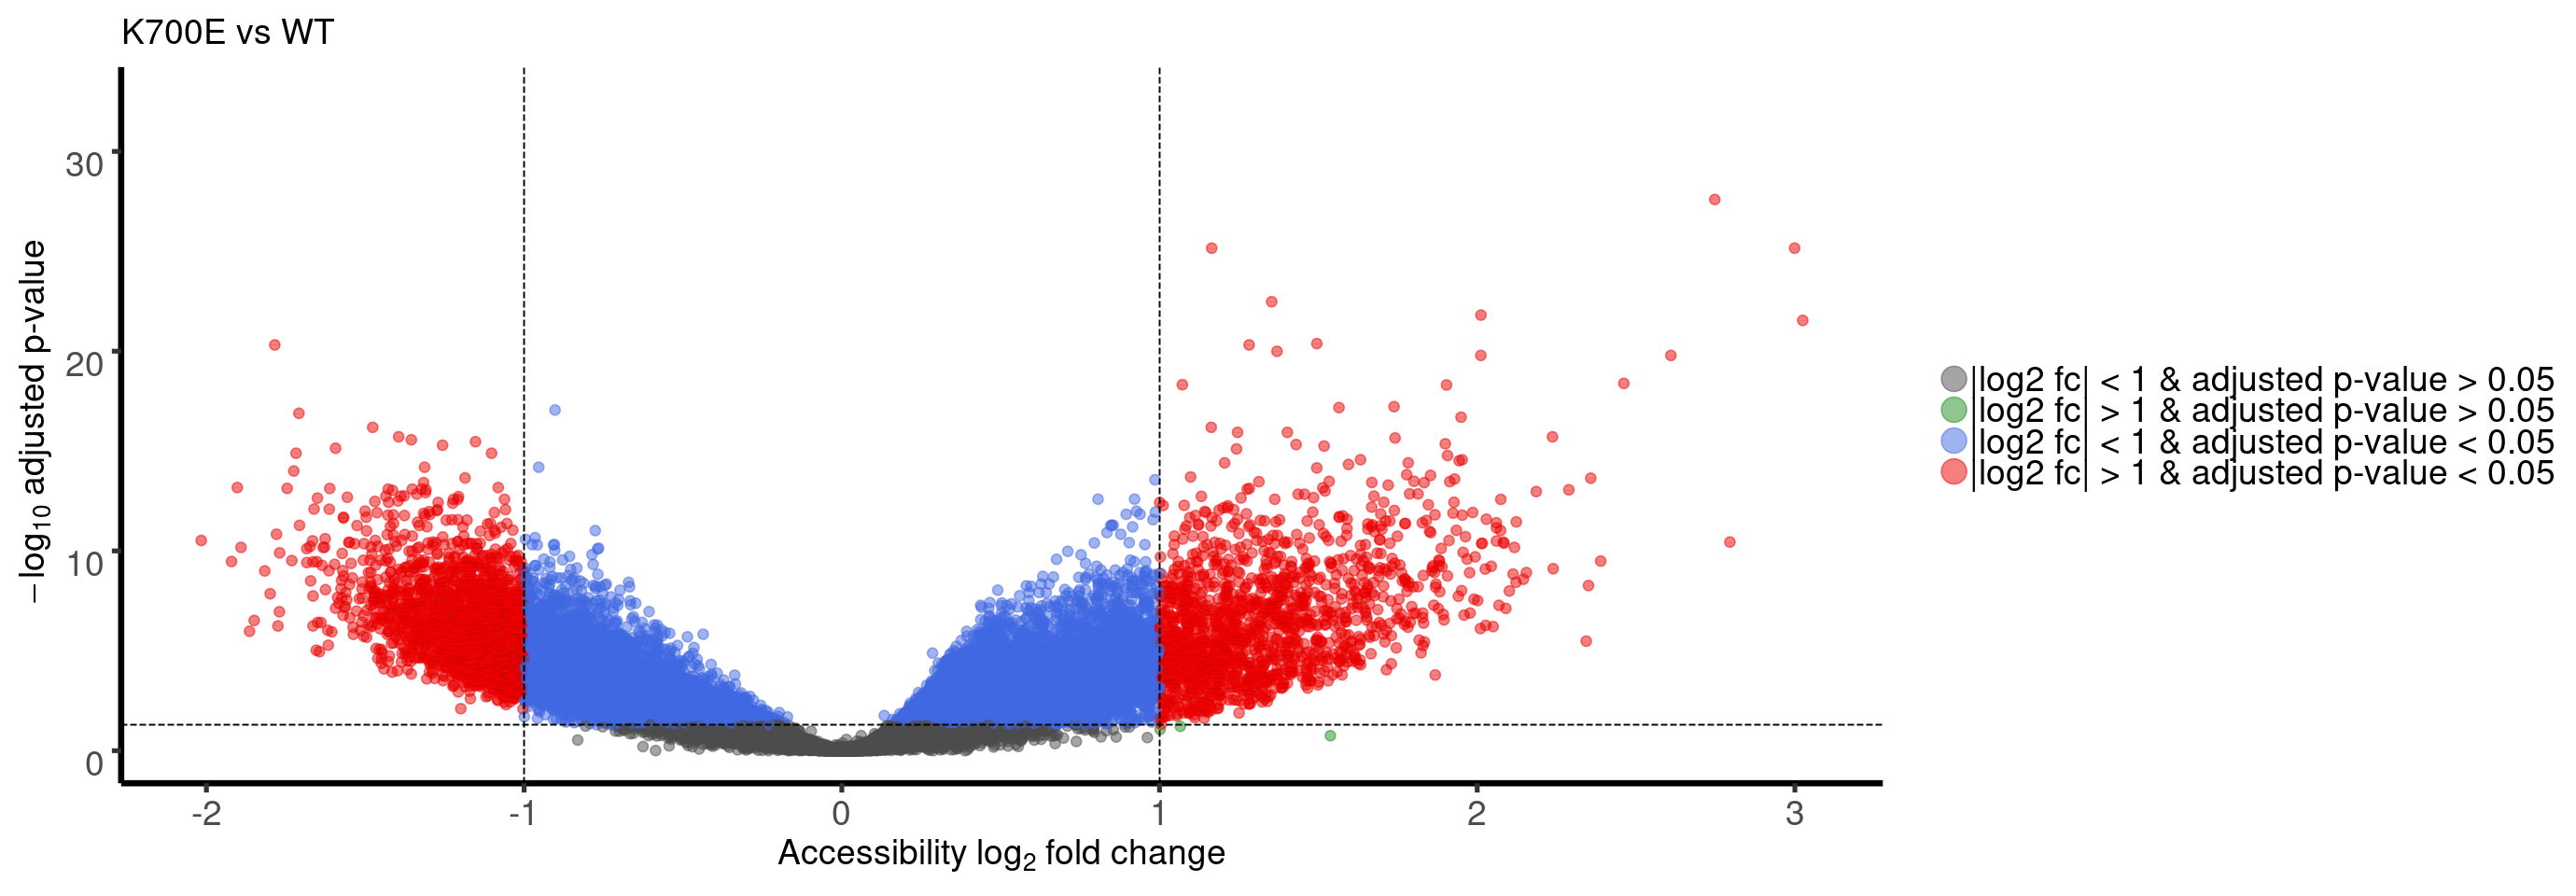

In [37]:
options(repr.plot.width=23, repr.plot.height=8)

EnhancedVolcano(project_res,lab = rownames(project_res),x = 'log2FoldChange',y = 'padj',title = "",xlab = bquote('Accessibility'~log[2]~'fold change'),
                borderWidth = 1.4, axisLabSize = 22,titleLabSize=22, ylab = bquote(~-log[10]~'adjusted p-value'),pCutoff = 0.05,FCcutoff = 1.0,
                legend=c('|log2 fc| < 1 & adjusted p-value > 0.05','|log2 fc| > 1 & adjusted p-value > 0.05',
                         '|log2 fc| < 1 & adjusted p-value < 0.05','|log2 fc| > 1 & adjusted p-value < 0.05'),
                legendPosition = 'right',legendLabSize = 22,legendIconSize = 7.0,  transcriptPointSize = 2.5,transcriptLabSize = 0,
                gridlines.major = FALSE, gridlines.minor = FALSE)+ ggtitle("K700E vs WT") + theme(text=element_text(family="Arial"),
                                                                                                  plot.title = element_text(face = "plain"))

Volcano plot for chromatin accessibility

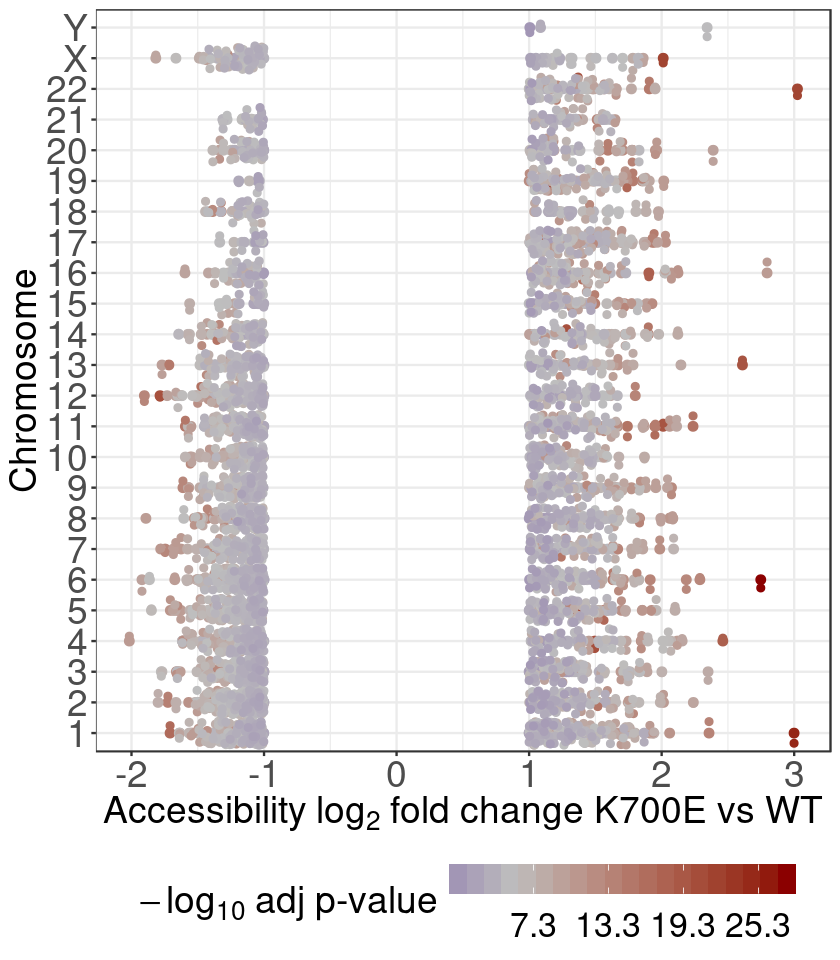

In [38]:
options(repr.plot.width=7, repr.plot.height=8)

toplot <- as.data.frame(project_diff_acc)
toplot$chr <- sapply(rownames(toplot),function(x){strsplit(x,"\\.")[[1]][[1]]})
toplot$padj <- -log(toplot$padj,10)
toplot$chr <- factor(toplot$chr, levels = c(as.character(c(1:22)),"X","Y"))

ggplot(toplot, aes(x=log2FoldChange, y=chr,color=padj)) + geom_point(size=2)+ theme_bw() + 
        theme(legend.position='bottom',legend.text=element_text(size=20),
              axis.text.x=element_text(angle=0,size=22),
              legend.title=element_text(size=22),
              plot.title=element_text(size=22),
              axis.text.y=element_text(size=22),
              axis.title=element_text(size=22))+ 
        scale_color_gradient2(low = "darkblue", high = "darkred", mid = "grey", 
                              midpoint = median(toplot$padj,na.rm=TRUE),
                              breaks=seq(round(min(toplot$padj,na.rm=TRUE),1),
                                         round(max(toplot$padj,na.rm=TRUE),1),6)) +
        guides(color = guide_colorbar(raster=F, direction='horizontal', barwidth = 14.4)) +
        labs(x=bquote('Accessibility'~log[2]~'fold change K700E vs WT'),y="Chromosome",
             color=bquote(~-log[10]~'adj p-value')) + geom_jitter() 

Genomic localization of differentially accessible peaks

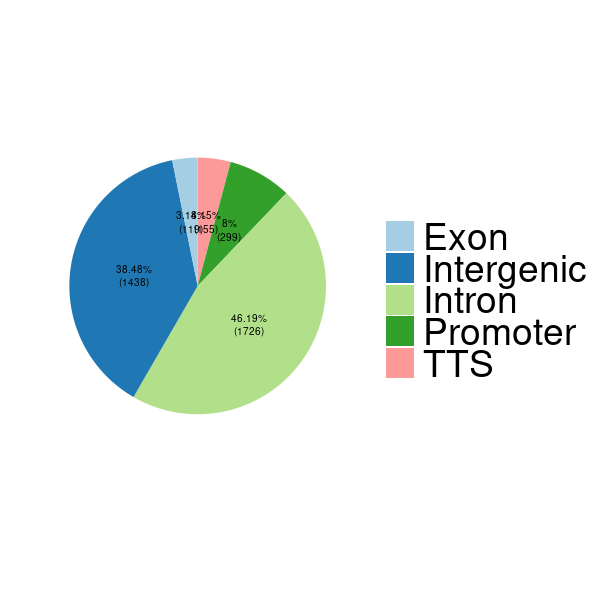

In [39]:
options(repr.plot.width=5, repr.plot.height=5)

homer_infile_stats <- paste(data_directory,"iPSC/statsAnnotation_Homer.txt",sep="")
common_homer_anno_stats <- read.table(homer_infile_stats,header=TRUE,sep="\t",fill=TRUE,quote="",nrows=5,stringsAsFactors = F)

common_homer_anno_stats["Freq"]<-(common_homer_anno_stats["Number.of.peaks"] / sum(common_homer_anno_stats["Number.of.peaks"]))*100

ggplot(common_homer_anno_stats, aes(x="",y=Freq, fill=Annotation))+
    geom_bar(width = 1, stat = "identity")+ theme_classic() +  coord_polar("y", start=0)+
    geom_text(aes(label = paste(round(Freq,2),"%\n","(",Number.of.peaks,")",sep="")),size=2,position = position_stack(vjust = 0.5),color="black")+
      theme(axis.line = element_blank(),axis.text = element_blank(),axis.ticks = element_blank(),legend.text=element_text(size=22))+       
        scale_fill_brewer(palette="Paired")+labs(x = "", y = "",fill = "")

#### Examining regulation of chromatin accessibility relatively to gene expression 

Quadrants showing the logfc of differentially accessible peaks relatively to the logfc of the gene they are mapped to

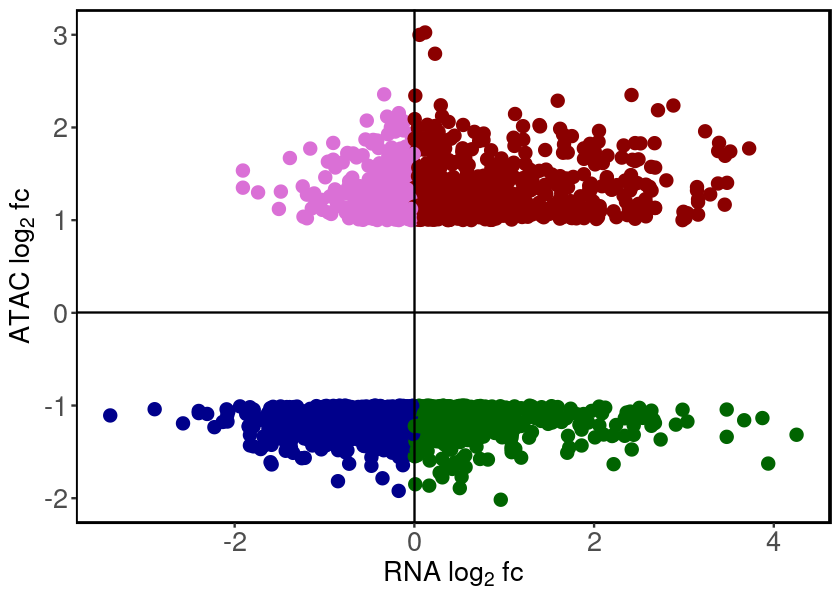

In [40]:
options(repr.plot.width=7, repr.plot.height=5)

infile <- paste(results_directory,"MDS_Normal_dacc_regions.txt",sep="")
d_across_all_intersect <- scan(infile, character(), quote = "")

homer_infile <- paste(data_directory,"iPSC/peakAnnotation_Homer.txt",sep="")
homer_anno <- read.table(homer_infile,header=TRUE,sep="\t",fill=TRUE,quote="",stringsAsFactors = FALSE)

homer_anno$regions_str <- paste(homer_anno$Chr,homer_anno$Start,homer_anno$End,sep=".")
rownames(homer_anno) <- homer_anno$regions_str
homer_anno <- homer_anno[d_across_all_intersect,]
n_genes <- as.character(homer_anno$assigned_gene)
        
infile <- paste(results_directory,"MDS_Normal_dge_mat_before_filt.txt",sep="")
d_mat_dge <- as.data.frame(read.table(infile,header=TRUE,row.names=1))
rownames(d_mat_dge)<-as.vector(sapply(rownames(d_mat_dge),function(x) {unique(annotation_map[which(annotation_map$GENEID==x),]$make_genename)}))
d_mat_dge <- d_mat_dge[unique(n_genes)[which(unique(n_genes) %in% rownames(d_mat_dge))],]

noexp <- which(is.na(d_mat_dge$baseMean))
if (length(noexp) == 0){       
        
    d_mat_dge <- d_mat_dge

}else {
    
    d_mat_dge <- d_mat_dge[-noexp,]
}

noexp <- which(is.na(d_mat_dge$padj))
if (length(noexp) == 0){       
        
    d_mat_dge <- d_mat_dge

}else {
    
    d_mat_dge <- d_mat_dge[-noexp,]
}

homer_anno <- homer_anno[which(homer_anno$assigned_gene %in% rownames(d_mat_dge)),]

infile <- paste(results_directory,"MDS_Normal_dacc_sortchr.txt",sep="")
d_mat <- as.data.frame(read.table(infile,header=TRUE,row.names=1))[rownames(homer_anno),]

df <- data.frame(peaks = rownames(d_mat) ,genes=as.character(homer_anno$assigned_gene),RNALFC=sapply(homer_anno$assigned_gene, function(y){d_mat_dge[y,]$log2FoldChange}),
                        RNA_padjvalue=sapply(homer_anno$assigned_gene, function(y){d_mat_dge[y,]$padj}), stat_significant="no",
                        ATACLFC=d_mat$log2FoldChange,stringsAsFactors=FALSE)

sets <- list(NULL,NULL,NULL,NULL)
df$tocolor <- "no"

for (i in 1:dim(df)[1]){
    
    if ((df[i,"ATACLFC"]>0) && (df[i,"RNALFC"]>0)){
        
        df[i,"tocolor"] <- "ATAC up & RNA up"
        sets[[1]] <- append(sets[[1]],rownames(df)[i])
    
    }else if (df[i,"ATACLFC"]<0 && df[i,"RNALFC"]>0){
        
        df[i,"tocolor"] <- "ATAC down & RNA up"
        sets[[2]] <- append(sets[[2]],rownames(df)[i])

    }else if (df[i,"ATACLFC"]>0 && df[i,"RNALFC"]< 0){
        
        df[i,"tocolor"] <- "ATAC up & RNA down"
        sets[[3]] <- append(sets[[3]],rownames(df)[i])

    }else if (df[i,"ATACLFC"]<0 && df[i,"RNALFC"]< 0){
        
        df[i,"tocolor"] <- "ATAC down & RNA down"
        sets[[4]] <- append(sets[[4]],rownames(df)[i])
    }
}

ggplot(df, aes(y=ATACLFC, x=RNALFC)) + geom_point(aes(color = tocolor), size = 3)+theme_bw() + theme(legend.text=element_text(size=16, family='Arial'),legend.title=element_text(size=16, family='Arial'),
                                                                                                     axis.text=element_text(size=16,family='Arial'),axis.title=element_text(size=16, family='Arial'),
                                                                                                     plot.subtitle=element_text(size=16, family='Arial'),plot.title=element_text(size=16,family='Arial'),
                                                                                                     panel.grid.major = element_blank(),panel.grid.minor = element_blank(), 
                                                                                                     panel.border = element_rect(colour = "black", fill=NA, size=1)) +
        labs(y=bquote('ATAC'~log[2]~'fc'),x=bquote('RNA'~log[2]~'fc'),color="") + 
        scale_color_manual(labels = c("Less accessible & less expressed in K700E","Less accessible & more expressed in K700E",
                                      "More accessible & less expressed in K700E","More accessible & more expressed in K700E","no"),
                           values=c("darkblue","darkgreen","orchid","red4","lightgrey"))+
        geom_vline(xintercept=0, color = "black",size=0.5)+ geom_hline(yintercept=0, color = "black",size=0.5) +
        guides(color = FALSE)

Plot of gene expression CDFs for genes more/less accessible in SF3B1 mutants 

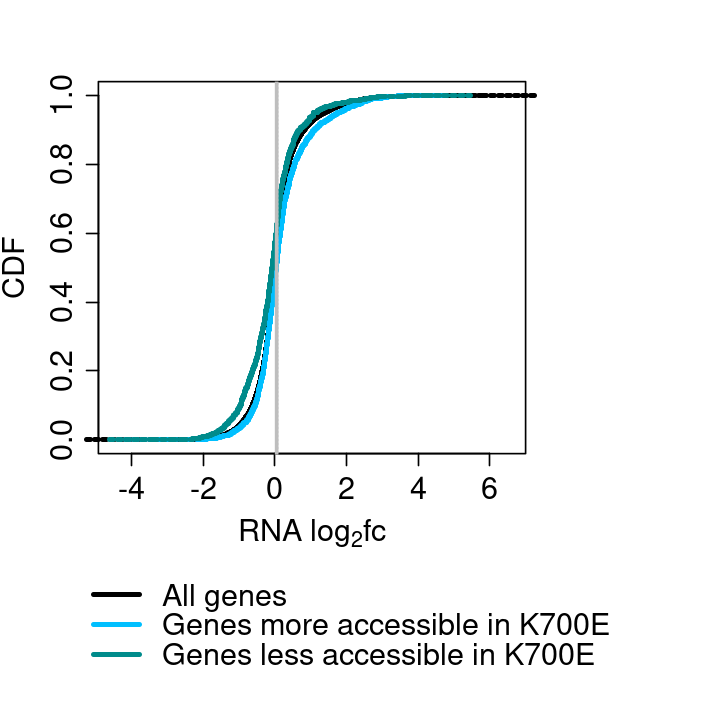

In [55]:
options(repr.plot.width=6, repr.plot.height=6)

homer_infile <- paste(data_directory,"iPSC/universal_peakAnnotation_Homer.txt",sep="")
homer_anno_universal <- read.table(homer_infile,header=TRUE,sep="\t",fill=TRUE,quote="",stringsAsFactors = F)

homer_anno_universal$regions_str <- paste(homer_anno_universal$Chr,homer_anno_universal$Start,homer_anno_universal$End,sep=".")
rownames(homer_anno_universal) <- homer_anno_universal$regions_str
n_genes_universal <- unique(as.character(homer_anno_universal$assigned_gene))

infile <- paste(data_directory,"iPSC/downreg_acc_genes.txt",sep="")
final_downreg_genes <- as.vector(scan(infile, character(), quote = ""))

infile <- paste(data_directory,"iPSC/upreg_acc_genes.txt",sep="")
final_upreg_genes <- as.vector(scan(infile, character(), quote = ""))
    
infile <- paste(results_directory,"MDS_Normal_dge_mat_before_filt.txt",sep="")
d_mat_dge <- as.data.frame(read.table(infile,header=TRUE,row.names=1))
rownames(d_mat_dge)<-as.vector(sapply(rownames(d_mat_dge),function(x) {unique(annotation_map[which(annotation_map$GENEID==x),]$make_genename)}))
    
tocompare <- d_mat_dge[n_genes_universal[which(n_genes_universal %in% rownames(d_mat_dge))],]

noexp <- which(is.na(tocompare$baseMean))    
if (length(noexp) == 0){       
        
    tocompare <- tocompare

}else {
    
    tocompare <- tocompare[-noexp,]
}

noexp <- which(is.na(tocompare$padj))    
if (length(noexp) == 0){       
        
    tocompare <- tocompare

}else {
    
    tocompare <- tocompare[-noexp,]
}

noexp <- which(is.na(tocompare$log2FoldChange))
if (length(noexp) == 0){       
        
    tocompare <- tocompare
    
}else {
    
    tocompare <- tocompare[-noexp,]
}
    
up_d_mat_dge <- d_mat_dge[final_upreg_genes[which(final_upreg_genes %in% rownames(d_mat_dge))],]

noexp <- which(is.na(up_d_mat_dge$baseMean))
if (length(noexp) == 0){       
        
    up_d_mat_dge <- up_d_mat_dge

}else {
    
    up_d_mat_dge <- up_d_mat_dge[-noexp,]
}

noexp <- which(is.na(up_d_mat_dge$padj))
if (length(noexp) == 0){       
        
    up_d_mat_dge <- up_d_mat_dge

}else {
    
    up_d_mat_dge <- up_d_mat_dge[-noexp,]
}

noexp <- which(is.na(up_d_mat_dge$log2FoldChange))
if (length(noexp) == 0){       
        
    up_d_mat_dge <- up_d_mat_dge

}else {
    
    up_d_mat_dge <- up_d_mat_dge[-noexp,]
}

x_up <- up_d_mat_dge$log2FoldChange
            
down_d_mat_dge <- d_mat_dge[final_downreg_genes[which(final_downreg_genes %in% rownames(d_mat_dge))],]
    
noexp <- which(is.na(down_d_mat_dge$baseMean))
if (length(noexp) == 0){       
        
    down_d_mat_dge <- down_d_mat_dge

}else {
    
    down_d_mat_dge <- down_d_mat_dge[-noexp,]
    }

noexp <- which(is.na(down_d_mat_dge$padj))
if (length(noexp) == 0){       
        
    down_d_mat_dge <- down_d_mat_dge

}else {
    
    down_d_mat_dge <- down_d_mat_dge[-noexp,]
}
    
noexp <- which(is.na(down_d_mat_dge$log2FoldChange))
if (length(noexp) == 0){       
        
    down_d_mat_dge <- down_d_mat_dge

}else {
    
    down_d_mat_dge <- down_d_mat_dge[-noexp,]
}

x_down <- down_d_mat_dge$log2FoldChange
        
tocompare_df <- tocompare

tocompare <- tocompare$log2FoldChange
    
p_up <- ecdf(x_up)
p_down <- ecdf(x_down)
p_all <- ecdf(tocompare)

par(mar=c(11.1, 4.1, 3.4, 8.1),xpd=TRUE, family = 'Arial')
plot(p_all,main="",xlab=expression('RNA log'[2]*'fc'),ylab="CDF",col="black", col.lab="black",
     cex.sub=0.8,col.sub="gray42",lwd=3, lty=2, col.01line = NULL,cex.lab=1.5,cex.axis=1.5,
     cex.main=1.5,font.main = 1) 

plot(p_up, verticals=TRUE, do.points=FALSE, add=TRUE, col='deepskyblue1',lwd=3, lty=2,col.01line = NULL)
plot(p_down, verticals=TRUE, do.points=FALSE, add=TRUE, col='darkcyan',lwd=3, lty=2,col.01line = NULL)
legend("topright", inset=c(-0.05,1.3), legend=c("All genes","Genes more accessible in K700E","Genes less accessible in K700E"), 
       col=c("black","deepskyblue1","darkcyan"),lwd=3,bty='n',cex=1.5)
ablineclip(v = 0,x1=0,x2=1, col="grey", lwd=5, lty=3)

In [42]:
ks.test(x_down,tocompare,alternative="greater")
ks.test(x_up,tocompare,alternative="less")

Warning message in ks.test(x_down, tocompare, alternative = "greater"):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  x_down and tocompare
D^+ = 0.11883, p-value = 3.133e-16
alternative hypothesis: the CDF of x lies above that of y


Warning message in ks.test(x_up, tocompare, alternative = "less"):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  x_up and tocompare
D^- = 0.064665, p-value = 1.167e-07
alternative hypothesis: the CDF of x lies below that of y


#### Correlation of iPSC chromatin profiles with chromatin landscape of normal hematopoietic celltypes from Corces et al.

Normalizing peak counts from iPSC and Corces et al. for a set of differentially accesible peaks between mutants and WT that overlap between both datasets 

In [43]:
average_celltypes<-function(cref,mat){
    
    for (i in (unique(unlist(cref)))){
        cols <- sapply(colnames(mat)[!colnames(mat) %in% unique(unlist(cref))],function(y) {strsplit(y,"_")[[1]][[2]]}) == i
        names(cols) <-NULL
        if (sum(cols)>1){
            mat<-transform(mat, i=rowMeans(mat[,cols]))[-which(cols==TRUE)]
            colnames(mat)[length(colnames(mat))]<-i
        }else{
            colnames(mat)[cols]<-i
            mat<-mat%>%select(-i,everything())
        }
    }
    return(mat)
}

celltypes_ref<-list(c("HSC","GMP","CMP","MEP","MPP","NK","Ery","CLP"),c("Bcell","NK"),c("HSC","GMP","CMP","MEP","MPP","Mono","Bcell","NK","LMPP"),
                    c("Bcell","NK","Ery","CLP"), c("HSC","GMP","CMP","MEP","MPP","Mono","LMPP"), c("HSC","GMP","CMP","MEP","MPP","Mono","LMPP"), c("Ery","CLP"))

load_counts_table <- paste(data_directory,"iPSC/peaks_count_Corces.txt",sep="")
count_df_Corces <- read.table(load_counts_table, row.names=1, header=TRUE)

mypeaks_file <- paste(data_directory,"iPSC/MDS_Normal_compCorces_counttable.txt",sep="")
mypeaks <- read.table(mypeaks_file, header=TRUE, row.names=1) 
isolate_Corces <- count_df_Corces[rownames(mypeaks),]

if (identical(rownames(mypeaks),rownames(isolate_Corces))){
    print("Free to move on")
}else{
    print("Check again")
}
    
mat_one<-cbind(mypeaks,isolate_Corces)

Group<-as.factor(as.vector(sapply(colnames(mat_one),function(x){paste(strsplit(x,"_")[[1]][c(1,2)],collapse="_")})))
metaData <- data.frame(Group,row.names=colnames(mat_one))
atacDDS <- DESeqDataSetFromMatrix(countData=mat_one,
                                            colData=metaData,
                                            design=~0+Group)

atacDDS$Group <- relevel(atacDDS$Group, ref = as.character(Group[1]))    
design_matrix <- model.matrix(~0+atacDDS$Group)
        
atacDDS <- DESeq(atacDDS)

rlognorm <- rlog(atacDDS, blind=FALSE)
norm_mat_one <-as.data.frame(assay(rlognorm))
ready_cor <- average_celltypes(celltypes_ref,norm_mat_one)
    
testcorpearpeak <- cor(ready_cor,method="pearson")
    
isolatecor <- testcorpearpeak[1:dim(mypeaks)[2],(dim(mypeaks)[2]+1):dim(testcorpearpeak)[2],drop=F]
    
llimit<-0
if (min(isolatecor)<0){
    llimit<-min(isolatecor)
}

[1] "Free to move on"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
rlog() may take a long time with 50 or more samples,
vst() is a much faster transformation


Plotting correlation map of chromatin landscapes

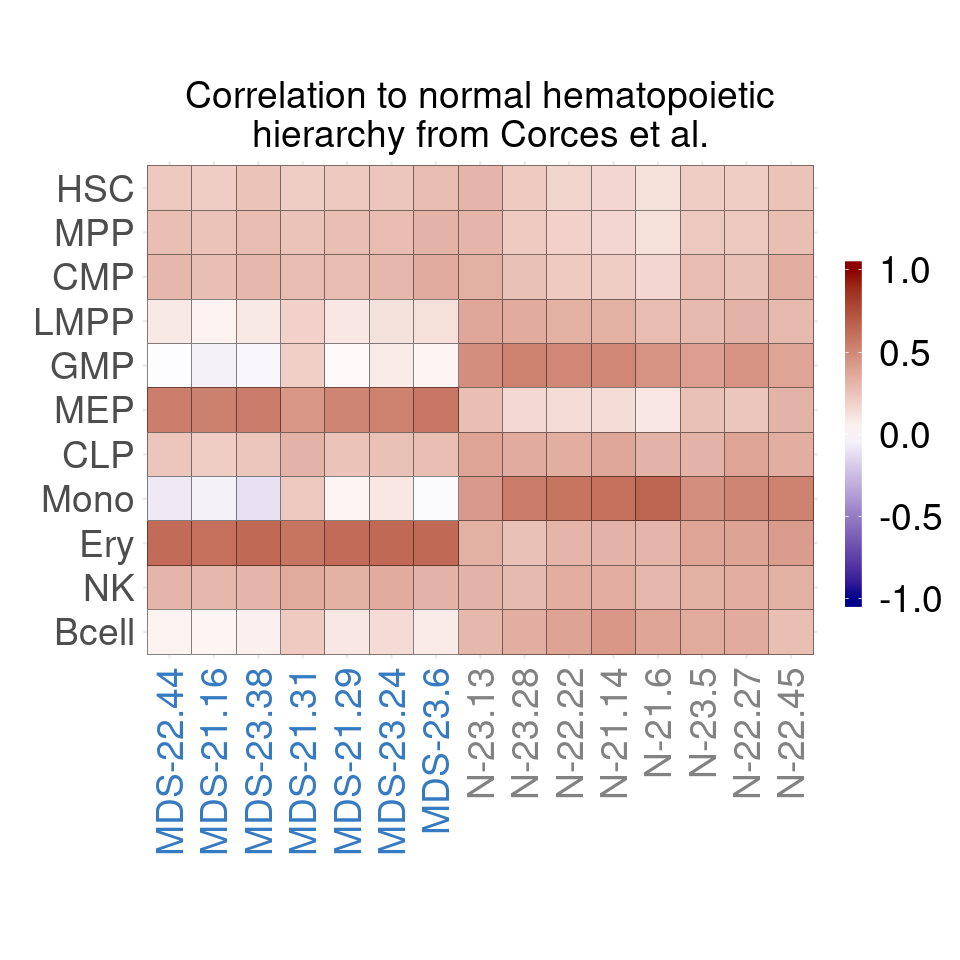

In [44]:
options(repr.plot.width=8, repr.plot.height=8)

data <- melt(isolatecor)
data$value <- round(data$value,digits=2)
data$Var1 <- str_replace(as.character(data$Var1),"Normal",'WT')
data$Var1 <- str_replace(as.character(data$Var1),"MDS",'Mutant')
    
data$Var1 <- gsub("sample","",data$Var1)
data$Var1 <- sub(".*?_","",data$Var1)
data$Var1 <- sapply(strsplit(data$Var1, "[_]"), function(x) if(length(x) >1) paste(x[1], paste(x[-1], collapse="."), sep="_") else x)
data$Var1 <- gsub("Mutant","MDS",data$Var1)

data$Var2 <- factor(data$Var2,levels=rev(c("HSC","MPP","CMP","LMPP","GMP","MEP","CLP","Mono","Ery","NK","Bcell")))
a <- ifelse(grepl("WT",levels(factor(data$Var1))),"#B0B2B1","#367BC1")

data$Var1 <- str_replace(data$Var1,"_","-")
data$Var1 <- str_replace(data$Var1,"WT","N")
data$Var1 <- str_replace(data$Var1,"MDS-22.44b","MDS-22.44")

a <- str_replace(a,'#B0B2B1',"gray51")

data$Var1 <- factor(data$Var1,levels = c("MDS-22.44","MDS-21.16","MDS-23.38","MDS-21.31","MDS-21.29","MDS-23.24","MDS-23.6","N-23.13","N-23.28","N-22.22","N-21.14","N-21.6","N-23.5","N-22.27","N-22.45"))
ggplot(data = data, aes(x=factor(Var1), y=Var2, fill=value)) + geom_tile(color = "black",height=1,width=1)+
        scale_fill_gradient2(low = "darkblue", high = "darkred", mid = "white", midpoint = 0, 
                             limit = c(-1,1),name="") + 
        theme_minimal()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,
                                                          size=22,family="Arial",color=a),
                               axis.text.y = element_text(size=22,family="Arial"),
                               legend.text=element_text(size=22,family="Arial"),
                               legend.title=element_text(size=22,family="Arial"),
                               plot.title=element_text(size=22,hjust=0.5,family="Arial"))+ 
        guides(fill = guide_colourbar(barwidth = 0.7, barheight = 14.4))+ labs(x="",y="")+ coord_fixed() + 
        ggtitle("Correlation to normal hematopoietic\nhierarchy from Corces et al.")                    

#### Motifs enriched in peaks more accessible in the mutants and assigned to upregulated genes

Reading motif enrichment dataframe

In [45]:
homer_infile <- paste(data_directory,"iPSC/motif_results.csv",sep="")
homer_motif <- read.table(homer_infile,header=T,sep="\t",quote="",stringsAsFactors = F)

infile <- paste(data_directory,"iPSC/motif_colors.rds",sep="")
motif_colors <- readRDS(infile)

Plotting the most statistically significant enriched motifs

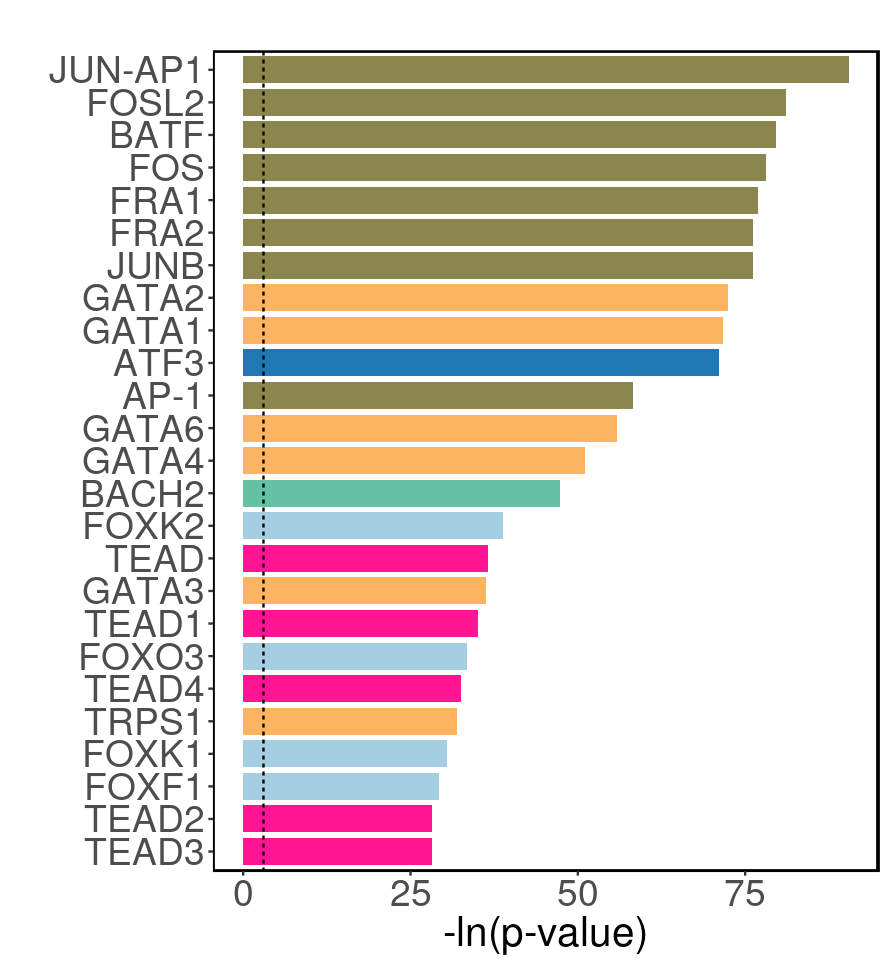

In [46]:
options(repr.plot.width=7.4, repr.plot.height=8)

toplot <- homer_motif
toplot$ln_pvalue <- -1*toplot$ln_pvalue
toplot <- toplot[order(toplot$ln_pvalue,decreasing=TRUE),]

toplot <- toplot[1:25,] #### plot the top25 motifs
cols <- motif_colors[unique(toplot$motif.family)]
toplot$motif_name <- factor(toplot$motif_name,levels=rev(toplot$motif_name))

ggplot(toplot, aes(y=ln_pvalue, x=motif_name,fill=motif.family))+ geom_bar(stat='identity',width=0.8) + labs(title= "",x="",y="-ln(p-value)",fill="")+
        ggtitle('')+ theme_bw()+ coord_flip()+ scale_fill_manual(values=cols)+ geom_hline(yintercept=-log(0.05), linetype="dashed", color = "black",size=0.5) +
        theme(legend.text=element_text(size=22,family='Arial'),axis.text=element_text(size=22,family='Arial'),
              legend.title=element_text(size=22,family='Arial'),axis.title=element_text(size=24,family='Arial'),
              plot.title=element_text(size=22,family='Arial'),panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), panel.border = element_rect(colour = "black", fill=NA, size=1))+
        guides(fill = FALSE)

Plotting the most prevalently enriched motif families

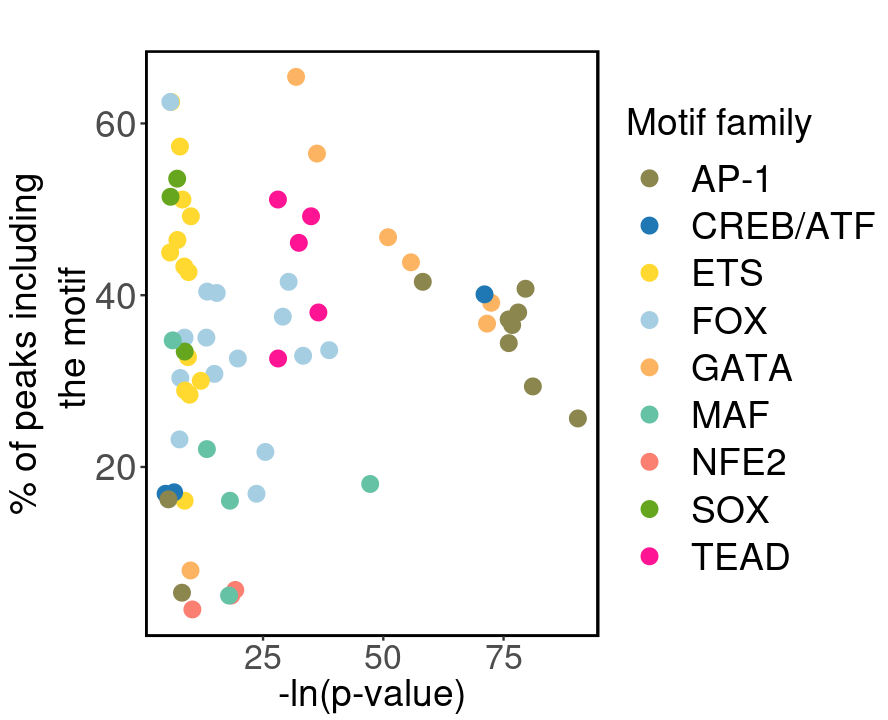

In [47]:
options(repr.plot.width=7.4, repr.plot.height=6)

motif_n <- homer_motif %>% 
  group_by(motif.family) %>% 
  summarise(count = n())

motif_n <- motif_n[order(motif_n$count,decreasing=T),]
motif_n <- motif_n[which(motif_n$count>=3),]

toplot <- homer_motif[which(homer_motif$motif.family %in% motif_n$motif.family),]
toplot$ln_pvalue <- -1*toplot$ln_pvalue
cols <- motif_colors[motif_n$motif.family]
toplot$motif_name <- factor(toplot$motif_name,levels=rev(motif_n$motif.family))

ggplot(toplot, aes(y=perc_target_sequences_with_motif, x=ln_pvalue,color=motif.family)) + geom_point(size=4)+
        theme_bw() + theme(panel.grid.major.x = element_blank(),panel.grid.major.y = element_blank(), 
                           legend.key.size = unit(1, "cm"), panel.grid.minor = element_blank(),
                           panel.border = element_rect(colour = "black", fill=NA, size=1),
                           legend.text=element_text(size=22,family='Arial'),
                           axis.text.x=element_text(angle=0,size=20,family='Arial'),
                           legend.title=element_text(size=22,family='Arial'),
                           plot.title=element_text(size=22,family='Arial'),
                           axis.text.y=element_text(size=22,family='Arial'),
                           axis.title=element_text(size=22,family='Arial'))+ 
        ggtitle("")+ labs(x="-ln(p-value)",y=expression(atop("% of peaks including", paste(" the motif"))),color="Motif family")+
        scale_color_manual(values=cols) + guides(size = FALSE,color = guide_legend(override.aes = list(size=4)))

Plotting the TPM expression of TEAD genes

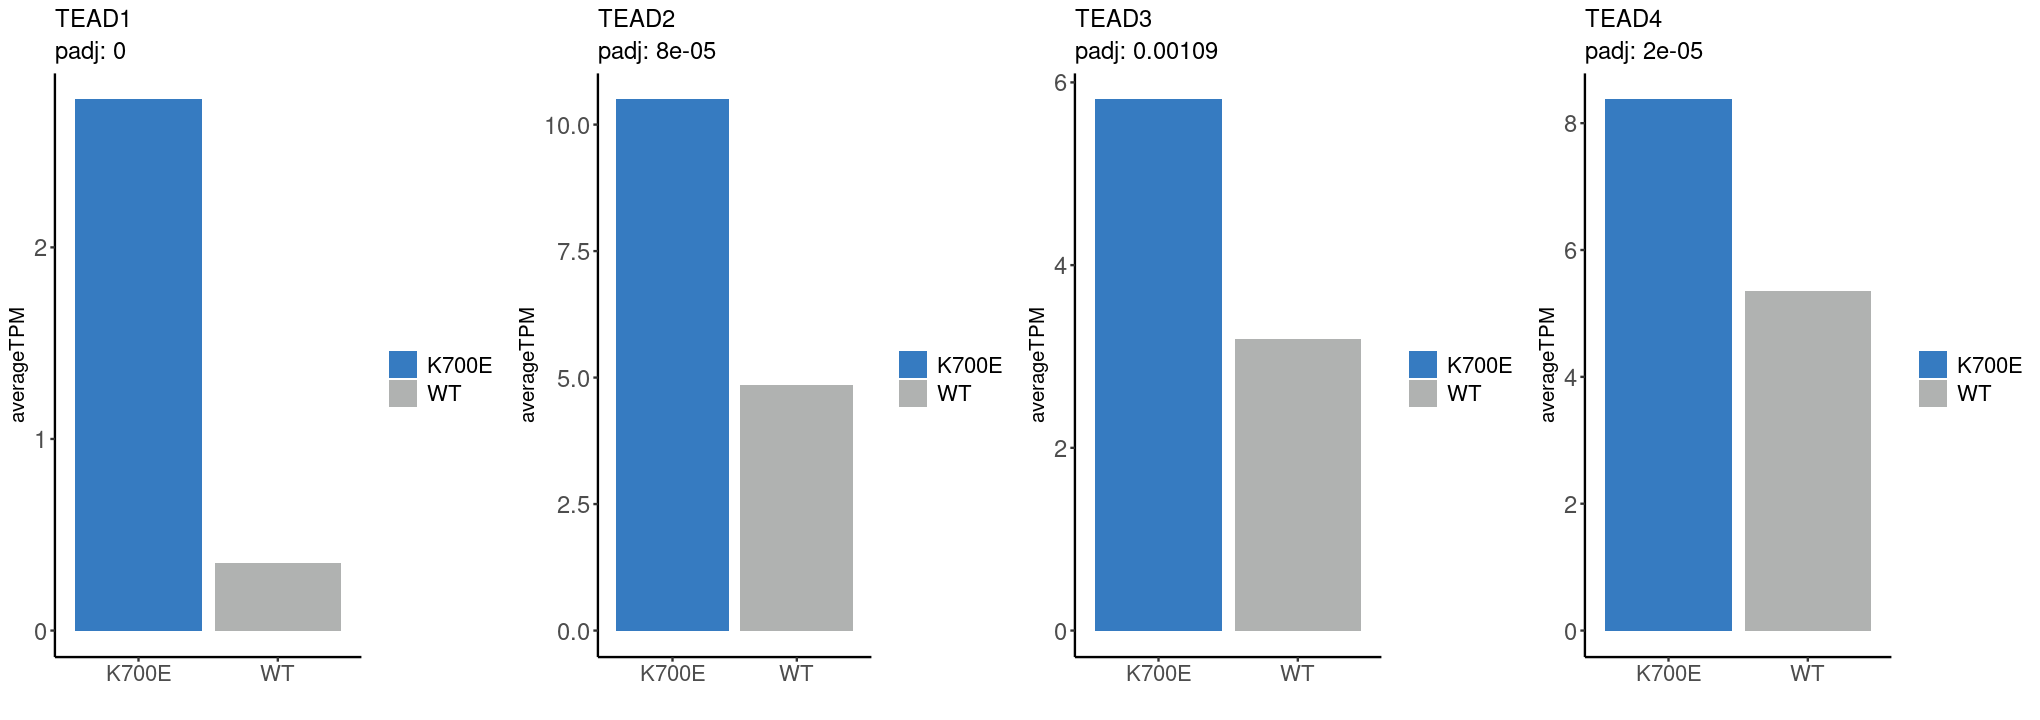

In [54]:
infile<-paste(data_directory,"iPSC/TPMs.txt",sep="")
TPM_toplot <- read.table(infile, header=T, sep="\t", stringsAsFactors = F)

infile<-paste(results_directory,"MDS_Normal_dge_mat_before_filt.txt",sep="")
lfc_all <- read.table(infile, row.names=1, header=TRUE,sep="\t",stringsAsFactors = F)
rownames(lfc_all)<-as.vector(sapply(rownames(lfc_all),function(x) {unique(annotation_map[which(annotation_map$GENEID==x),]$make_genename)}))

plt2 <- list()
pvals <- c()
temp_df_mean <- list()

for (tf in 1:4){
    
    temp_df <- as.data.frame(t(TPM_toplot[tf,]))
    colnames(temp_df) <- "tf"
    temp_df$donor <- as.character(sapply(rownames(temp_df), function(y){strsplit(y,"\\.")[[1]][[1]]}))
    temp_df$condition <- sapply(as.character(sapply(rownames(temp_df), function(y){strsplit(y,"\\.")[[1]][[2]]})),function(s){strsplit(s,"2")[[1]][[1]]})
    temp_df$condition <- str_replace(temp_df$condition,"N","WT")
    temp_df$condition <- str_replace(temp_df$condition,"MDS","K700E")
    temp_df$grouping <- (paste(temp_df$donor,temp_df$condition,sep="_"))
    temp_df$x <- rownames(temp_df)
    
    temp_df_mean[[tf]] <- group_by(temp_df,condition) %>% summarize(m = mean(tf))
        
    annpval <- lfc_all[rownames(TPM_toplot)[tf],"padj"]
    subann <- paste("padj: ",round(annpval, digits = 5),sep="")
    
    plt2[[tf]] <- ggplot(data=temp_df_mean[[tf]], aes(x=condition, y=m,fill=condition)) + geom_bar(stat="identity", position="dodge")+ theme_classic() + scale_fill_manual(values=c("#367BC1","#B0B2B1"),labels=c("K700E","WT"))+
                    theme(plot.subtitle=element_text(size=14),plot.title=element_text(size=14),
                          axis.title=element_text(size=12),legend.text=element_text(size=13),
                          axis.text.y=element_text(size=14),axis.text.x=element_text(size=13)) +
                    labs(fill="",x="", y = "averageTPM") + ggtitle(rownames(TPM_toplot)[tf],subtitle=subann)

}

options(repr.plot.width=17, repr.plot.height=6) 
grid.arrange(grobs=plt2, nrow=1 ,as.table=TRUE)